# **Exponential Smoothing (ETS) Modeling for Corporación Favorita Grocery Sales Forecasting**




## 1️⃣ Notebook Overview

This notebook implements and documents the full ETS modeling workflow for the
Corporación Favorita Grocery Sales Forecasting dataset, using the modular
pipeline defined in:

- `ETSPipeline` (end‑to‑end orchestration)
- `ETSEstimator` (model fitting & prediction)
- `ETSEvaluator` (metrics & diagnostics)
- `ETSConfig` (configuration management)

We will:

1. Load and inspect the raw sales data  
2. Run a **baseline ETS experiment** on a single store–item series  
3. Compare multiple ETS configurations  
4. Run **multi‑series** experiments across several store–item pairs  
5. Perform **cross‑validation** with different train/test splits  
6. Benchmark ETS performance (training, prediction, scalability)

## 2️⃣ Imports & configuration

### *2.1 configuration*

In [1]:
import os
import sys
# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

Clean sys.path:


In [2]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
# Project root
project_root = os.path.abspath(os.path.join(cwd, "../.."))
print("Project root:", project_root)



## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
# Add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)



print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_2
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis', '/opt/anaconda3/envs/retail_env/lib/python311.zip', '/opt/anaconda3/envs/retail_env/lib/python3.11', '/opt/anaconda3/envs/retail_env/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/retail_env/lib/python3.11/site-packages']
True


In [3]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


### *2.2 Core imports*

In [4]:
# Core imports
import logging
import time
from pathlib import Path

import numpy as np
import pandas as pd

# Display
from IPython.display import display, HTML




### *2.3 Project imports*

In [5]:
from src import(
    DataLoader,
    ETSPipeline, 
    ETSConfig,
    TSVisualization
)

### *2.3 Logging configuration*

In [6]:
# Logging configuration 
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


### *2.4 Experiment configuration*

In [7]:
# Experiment configuration (notebook version of ETSExperimentConfig)

class ETSNotebookConfig:
    # Data
    TABLE_NAME = "train_cleaned.csv"
    FOLDER_NAME = "cleaned"

    ALL_STORE_IDS = [24, 26, 27, 28, 30, 32, 34, 35, 51, 36, 29]
    ALL_ITEM_IDS = [105574, 105575, 105577, 2122868, 2123839, 2123775]

    DEFAULT_STORE_IDS = [24]
    DEFAULT_ITEM_IDS = [105577]
    MAX_DATE = None

    SPLIT_RATIO = 0.8

    WEEK = 2
    PREVIOUS_WEEK = 1

    USE_MLFLOW = True
    USE_CACHE = True

    # ----------------------------------------------------------------------
    # Model configurations with positivity strategies
    # ----------------------------------------------------------------------
    CONFIGURATIONS = {
        "baseline": {
            "trend": "additive",
            "seasonal": "additive",
            "seasonal_periods": 7,
            "damped": False,
            "positivity_strategy": "fallback",   # safe default
        },
        "damped_trend": {
            "trend": "additive",
            "seasonal": "additive",
            "seasonal_periods": 7,
            "damped": True,
            "positivity_strategy": "fallback",
        },
        "multiplicative": {
            "trend": "multiplicative",
            "seasonal": "multiplicative",
            "seasonal_periods": 7,
            "damped": False,
            "positivity_strategy": "shift",      # BEST for multiplicative
        },
        "no_trend": {
            "trend": None,
            "seasonal": "additive",
            "seasonal_periods": 7,
            "damped": False,
            "positivity_strategy": "fallback",
        },
    }

    # Multi-series experiment
    MULTI_SERIES = MULTI_SERIES = [ 
                                   ([24], [105577]), 
                                   ([24], [105574]), 
                                   ([26], [105577]), 
                                   ([26], [105575]), 
                                   ([27], [105577]), 
                                   ([51], [105577]), 
                                   ]

    CV_SPLIT_RATIOS = [0.70, 0.75, 0.80, 0.85, 0.90]



    



In [8]:
# Optional: set display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

###  *2.4 Utility helpers*

In [9]:
def print_header(title: str, char: str = "=", width: int = 80) -> None:
    border = char * width
    print(f"\n{border}\n{title.center(width)}\n{border}\n")


def print_section(title: str, char: str = "-", width: int = 80) -> None:
    print(f"\n{char * width}\n▶ {title}\n{char * width}\n")


def format_metrics(metrics: dict, precision: int = 2) -> str:
    lines = []
    lines.append(f"MAE:        {metrics['mae']:>{precision+7}.{precision}f}")
    lines.append(f"RMSE:       {metrics['rmse']:>{precision+7}.{precision}f}")
    lines.append(f"MAPE:       {metrics['mape']:>{precision+7}.{precision}f}%")
    lines.append(f"SMAPE:      {metrics['smape']:>{precision+7}.{precision}f}%")
    lines.append(f"MASE:       {metrics['mase']:>{precision+7}.{precision}f}")
    lines.append(f"R² Score:   {metrics['r2']:>{precision+7}.4f}")
    return "\n".join(lines)


## 3️⃣ Load and briefly inspect the data 



### *3.1 Load Cleaned Corporación Favorita dataset*

In [10]:
print_header("LOADING CORPORACIÓN FAVORITA SALES DATA", char="*")
ets_notebook_config = ETSNotebookConfig()
loader = DataLoader() 

train_df = loader.load_csv(
    folder_name=ets_notebook_config.FOLDER_NAME,
    table_name= ets_notebook_config.TABLE_NAME,
    week=ets_notebook_config.PREVIOUS_WEEK,
    use_cache=ets_notebook_config.USE_CACHE
)

train_df.head()


********************************************************************************
                    LOADING CORPORACIÓN FAVORITA SALES DATA                     
********************************************************************************

📖 Loading train_cleaned.csv with pandas from cleaned...
✅ Loaded train_cleaned.csv with shape (35069356, 6)


store_nbr  item_nbr        date      id  unit_sales  onpromotion
0         24    105574  2013-01-02   18790        12.0        False
1         24    105574  2013-01-03   59692         1.0        False
2         24    105574  2013-01-04   99664         3.0        False
3         24    105574  2013-01-05  140805         4.0        False
4         24    105574  2013-01-06  182800         7.0        False

### 3.2 *quick structural checks*


In [11]:
df= train_df.copy()
print_section("DATA STRUCTURE")
print(f"Rows: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")



--------------------------------------------------------------------------------
▶ DATA STRUCTURE
--------------------------------------------------------------------------------

Rows: 35,069,356
Columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion']


In [12]:
# Print unique store numbers
print("Unique store numbers in the dataset:")
print(train_df.store_nbr.unique())
print(train_df.store_nbr.nunique())

# Print unique item numbers
print("\nUnique item numbers in the dataset:")
print(train_df.item_nbr.unique())
print(train_df.item_nbr.nunique())


Unique store numbers in the dataset:
[24 26 27 28 30 32 34 35 51 36 29]
11

Unique item numbers in the dataset:
[ 105574  105575  105577 ... 2122868 2123839 2123775]
2323


## 4️⃣ Experiment 1 — Baseline ETS on a single series

### 4.1 Experiment 1: Baseline ETS forecasting for a single store–item series



We run the full `ETSPipeline` with default ETS configuration on:

- Store: 24  
- Item: 105577  

This executes:

1. Data preparation (filter, aggregate, calendar completion, TimeSeries conversion, split)
2. Model training (ETS)
3. Forecast generation
4. Evaluation & diagnostics


2026-01-05 17:23:10,659 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:10,661 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:10,661 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



                     EXPERIMENT 1: BASELINE ETS FORECASTING                     

[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller

  ETS Pipeline Initialized

📁 Results: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets
📊 Visualizations: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets
🤖 Models: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets

  STEP 1: DATA PREPARATION

🔧 Initializing data preparation...

────────────────────────────────────────────────────────────────────────────────
▶ Filtering Data
────────────────────────────────────────────────────────────────────

2026-01-05 17:23:14,495 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: calendar_data.csv

────────────────────────────────────────────────────────────────────────────────
▶ Converting to TimeSeries
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687

────────────────────────────────────────────────────────────────────────────────
▶ Splitting Train/Test
─────────────────────────────────────────────────────────────────────

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

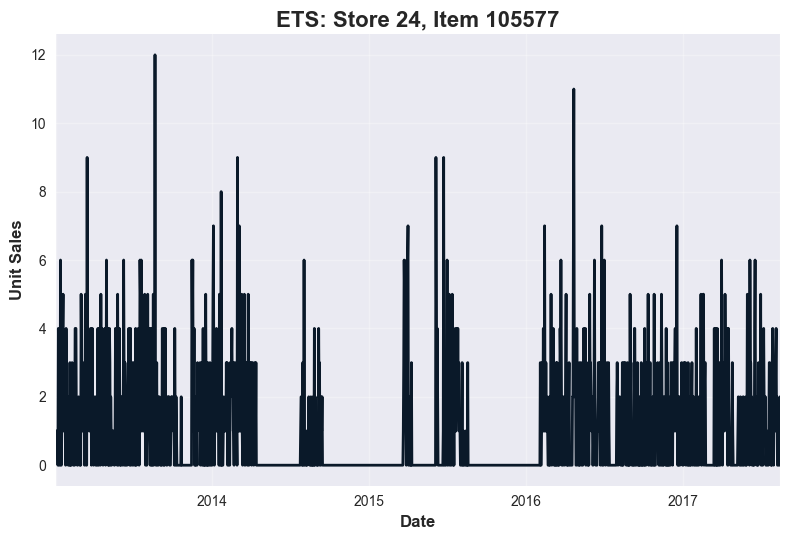

[TimeSeriesViz] Generating enhanced forecast overlay...


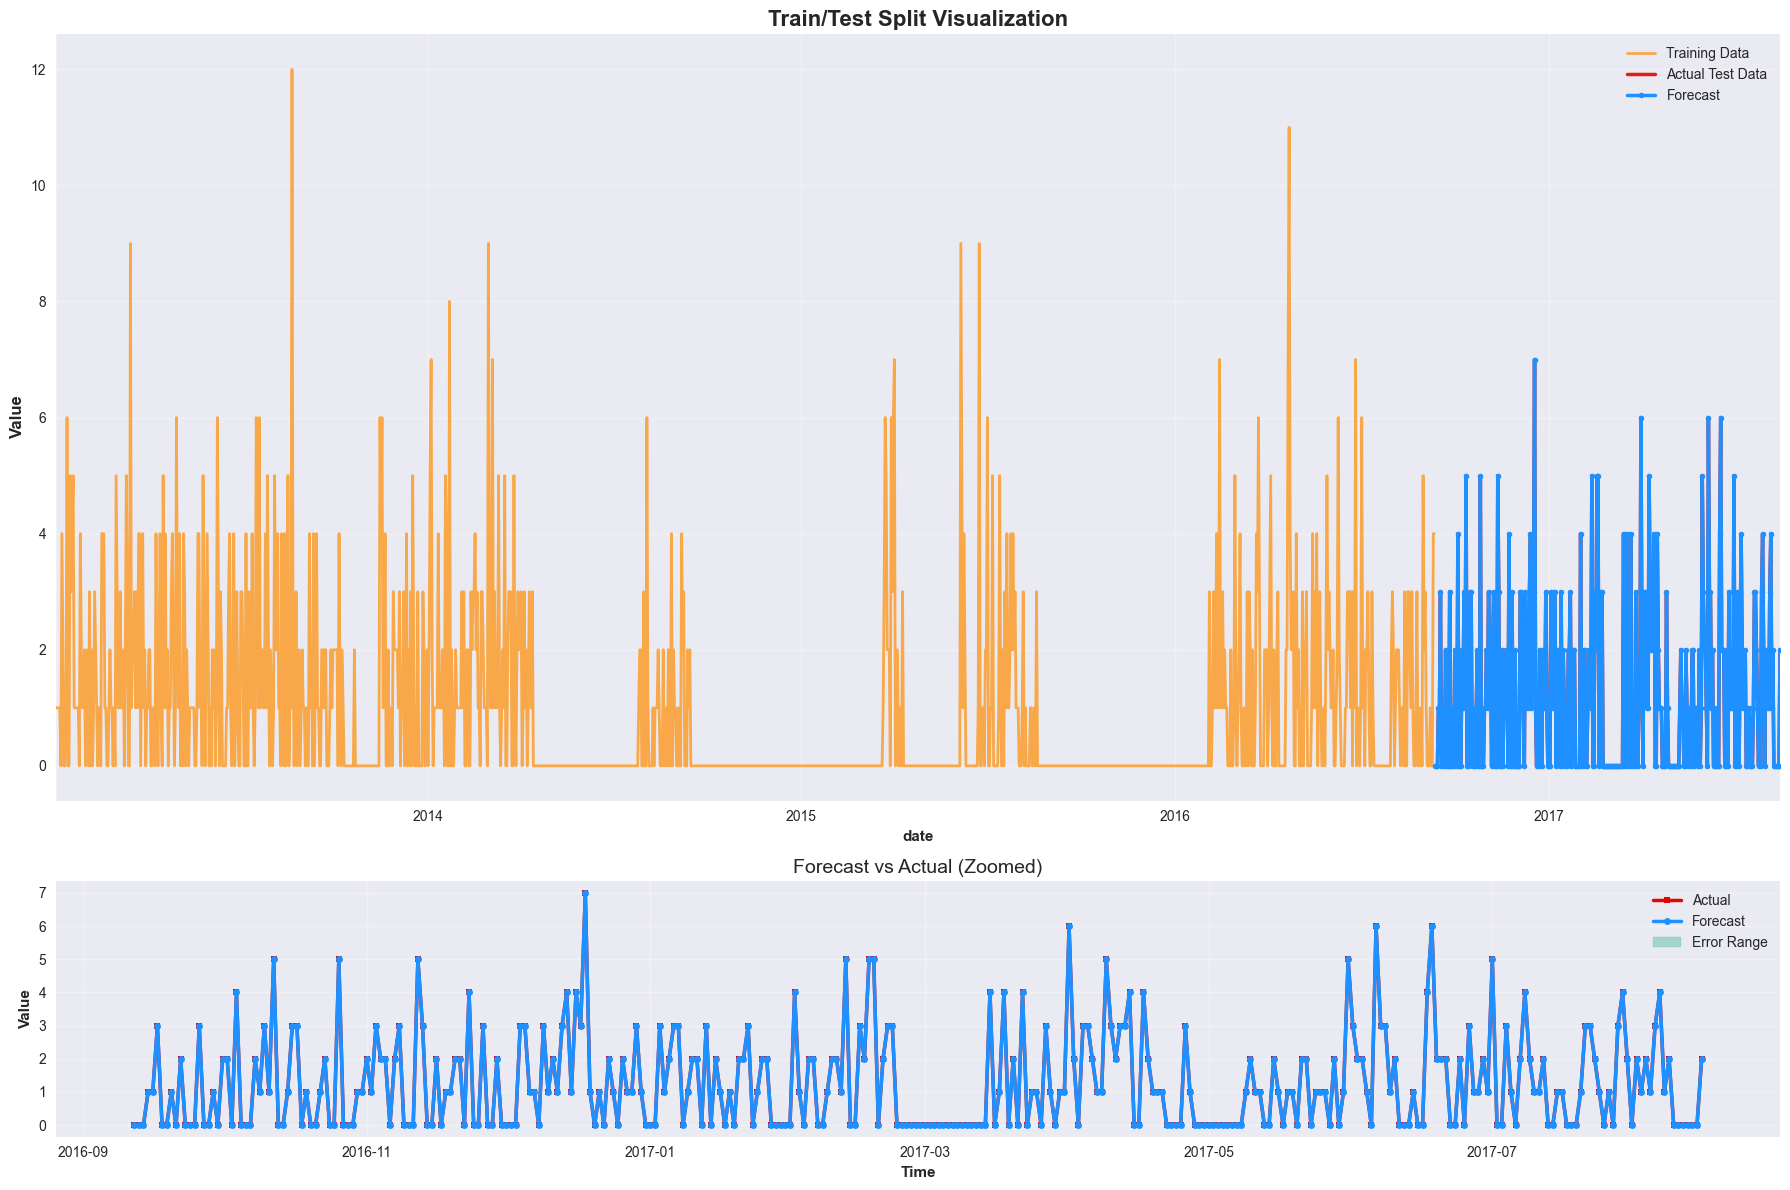

2026-01-05 17:23:15,542 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:15,544 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful


  STEP 2: TRAIN ETS MODEL



2026-01-05 17:23:15,548 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:15,548 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:15,729 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:15,731 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:15,731 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation



────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
💾 Model saved: ets_model_week2.pkl
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json

✅ Step 2 Complete: Model training successful


  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📊 Forecasting 338 periods...


2026-01-05 17:23:15,742 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/forecast_vs_actual.csv


💾 Forecast data saved: forecast_vs_actual.csv

────────────────────────────────────────────────────────────────────────────────
▶ Visualizing Forecast
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating enhanced forecast overlay...


2026-01-05 17:23:16,330 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:16,330 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:16,330 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:16,334 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0262)
2026-01-05 17:23:16,334 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png

✅ Step 3 Complete: Forecast generation successful


  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
✅ ETS evaluation completed



ETS MODEL EVALUATION SUMMARY

Observations: 338

📊 Accuracy Metrics:
  MAE:   1.2073
  RMSE:  1.4380
  MAPE:  5910855832.90%
  SMAPE: 113.67%
  R²:    0.0191

📏 Scaled Metrics:
  MASE:  0.8962
  RMSSE: 0.7502

🔬 Diagnostics:
  ACF(1): 0.1419
  Ljung-Box p-value: 0.0262

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────


2026/01/05 17:23:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/05 17:23:16 INFO mlflow.store.db.utils: Updating database tables
2026/01/05 17:23:16 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/05 17:23:16 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/05 17:23:16 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/05 17:23:16 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026-01-05 17:23:16,803 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:16,803 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed


📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Results logged to MLflow

✅ Step 4 Complete: Model evaluation successful


--------------------------------------------------------------------------------
▶ BASELINE RESULTS
--------------------------------------------------------------------------------

MAE:             1.21
RMSE:            1.44
MAPE:       5910855832.90%
SMAPE:         113.67%
MASE:            0.90
R² Score:      0.0191

⏱️ Execution time: 6.15 seconds


In [13]:
print_header("EXPERIMENT 1: BASELINE ETS FORECASTING")

start_time = time.time()

pipeline_baseline = ETSPipeline(
    store_ids=ETSNotebookConfig.DEFAULT_STORE_IDS,
    item_ids=ETSNotebookConfig.DEFAULT_ITEM_IDS,
    max_date=ETSNotebookConfig.MAX_DATE,
    week=ETSNotebookConfig.WEEK,
    verbose=True,
    use_mlflow=ETSNotebookConfig.USE_MLFLOW,
)

train, test = pipeline_baseline.prepare_data(
    df,
    split_ratio=ETSNotebookConfig.SPLIT_RATIO,
)

try:
    # Train model (may skip if multiplicative invalid)
    pipeline_baseline.train_model()

except RuntimeError as e:
    if "SKIP_CONFIGURATION" in str(e):
        print("\n⚠️ Baseline configuration skipped due to multiplicative ETS constraints.")
        print("   → Baseline results cannot be computed for this configuration.")
        print_section("BASELINE RESULTS")
        print("Status: SKIPPED")
        print(f"⏱️ Execution time: {time.time() - start_time:.2f} seconds")
        # Stop baseline experiment cleanly
        baseline_results = {"status": "skipped"}
        
    else:
        raise

# Continue only if training succeeded
pipeline_baseline.generate_forecast()
metrics_baseline = pipeline_baseline.evaluate_model()

elapsed_time = time.time() - start_time

print_section("BASELINE RESULTS")
print(format_metrics(metrics_baseline))
print(f"\n⏱️ Execution time: {elapsed_time:.2f} seconds")



### *4.2 ETS Forecasting for Store 24, Item 105577*

---

#### **4.2.1. Introduction**
In this analysis, we applied **Exponential Smoothing (ETS)** to forecast the demand for **Item 105577** at **Store 24** using historical sales data from **2013 to 2017**. The goal was to predict future demand and evaluate the model’s accuracy.

<br>

#### **4.2.2. Data Preparation & Exploration**
##### *4.2.2.1 Dataset Overview*
- **Total Observations:** 1,687 days of sales data
- **Train/Test Split:** 80% training (1,349 days), 20% testing (338 days)
- **Time Range:**
  - Training: **2013-01-02 → 2016-09-11**
  - Testing: **2016-09-12 → 2017-08-15**

##### *4.2.2.2Key Observations from the Data*
- **Sales Pattern:** The data shows **spikes in demand**, especially around certain periods (e.g., holidays or promotions).
- **Average Daily Sales:**
  - **Training Set:** ~1.3 units/day
  - **Test Set:** ~1.27 units/day
- **Volatility:** High variability in sales, with some days reaching **up to 12 units** and others having **zero sales**.


<br>

### **4.2.3. Model Training & Configuration**
#### *4.2.3.1 ETS Model Parameters*
- **Trend:** Additive
- **Seasonality:** Additive (weekly seasonality, `seasonal_periods=7`)
- **Damped Trend:** No

The model was trained on **1,349 days** of historical data to capture both **trend and seasonality**.

<br>

### **4.2.4. Forecasting Results**
#### *4.2.4.1 Forecast Summary*
- **Forecast Period:** 338 days (2016-09-12 to 2017-08-15)
- **Average Forecasted Demand:** **1.42 units/day**
- **Actual Average Demand:** **1.27 units/day**

#### *4.2.4.2 Visual Comparison*
The forecast (blue) closely follows the **actual test data (red)** but struggles with **sudden spikes** in demand.


<br>

### **4.2.5. Model Performance Evaluation**
#### *4.2.5.1 Key Metrics*
| Metric       | Value         | Interpretation                                                                 |
|--------------|---------------|-------------------------------------------------------------------------------|
| **MAE**      | **1.21**      | On average, the forecast is off by **1.21 units/day**.                        |
| **RMSE**     | **1.44**      | Larger errors are penalized more, indicating some **high-magnitude misses**.   |
| **MAPE**     | **5,910,855,832.9%** | **Extremely high** due to division by near-zero actual values.                |
| **SMAPE**    | **113.67%**   | The forecast is off by **113.67%** on average (symmetric error).               |
| **MASE**     | **0.90**      | The model performs **90% of the naive forecast’s error**.                     |
| **R² Score** | **0.019**     | Only **1.9% of variance** in sales is explained by the model.                 |

#### *4.2.4.2 Diagnostics*
- **Ljung-Box Test:** Significant autocorrelation detected (`p=0.0262`), suggesting **residual patterns** that the model did not capture.
- **ACF(1):** **0.1419**, indicating some **short-term dependency** in residuals.

<br>

### **4.2.6. Insights & Recommendations**
#### **4.2.6.1 Strengths**
✅ The model captures **general trends** in demand.
✅ It performs reasonably well for **low-volatility periods**.

#### **4.2.6.2 Weaknesses**
❌ **Struggles with spikes** in demand (e.g., promotions, holidays).
❌ **Low R² (1.9%)** suggests the model does not explain much variance.
❌ **High MAPE (5.9B%)** is misleading due to near-zero sales days.

#### **4.2.6.3 Recommendations**
🔹 **Improve Feature Engineering:**
   - Incorporate **holiday flags** and **promotion data** to better capture spikes.
   - Use **external regressors** (e.g., price changes, competitor activity).

🔹 **Try Alternative Models:**
   - **SARIMA** (for better seasonality handling).
   - **Prophet** (for robustness to outliers).
   - **Machine Learning (XGBoost, Random Forest)** for non-linear patterns.

🔹 **Adjust Evaluation Metrics:**
   - **Ignore MAPE** due to zero/near-zero sales.
   - Focus on **MAE, RMSE, and MASE** for a fairer assessment.

<br>

### **4.2.7. Conclusion**
The **ETS model provides a baseline forecast** but has **limited accuracy** for this high-volatility item. Future improvements should focus on **better feature engineering** and **alternative modeling approaches** to capture demand spikes effectively.

<br>
**Execution Time:** **5.84 seconds** ✅


## 5️⃣ Experiment 2 — ETS configuration comparison

### 5.1.  Experiment 2: Comparing multiple ETS configurations

We compare several ETS setups (trend/seasonality/damping) on the same store–item series.


2026-01-05 17:23:16,919 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:16,920 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:16,920 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting full pipeline execution
2026-01-05 17:23:16,920 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



          EXPERIMENT 2: CONFIGURATION COMPARISON (DEBUG MODE ENABLED)           



--------------------------------------------------------------------------------
▶ Configuration: BASELINE
--------------------------------------------------------------------------------

🔧 Raw Parameters: {'trend': 'additive', 'seasonal': 'additive', 'seasonal_periods': 7, 'damped': False, 'positivity_strategy': 'fallback'}

[1] Initializing Pipeline...
[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller

  ETS Pipeline Initialized

📁 Results: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets
📊 Visualizations: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets
🤖 Models:

2026-01-05 17:23:20,597 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: calendar_data.csv

────────────────────────────────────────────────────────────────────────────────
▶ Converting to TimeSeries
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687

────────────────────────────────────────────────────────────────────────────────
▶ Splitting Train/Test
─────────────────────────────────────────────────────────────────────

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

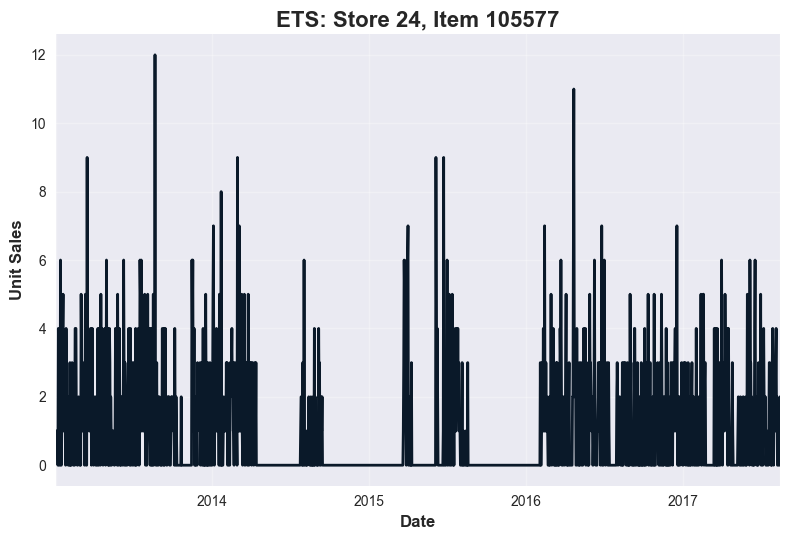

[TimeSeriesViz] Generating enhanced forecast overlay...


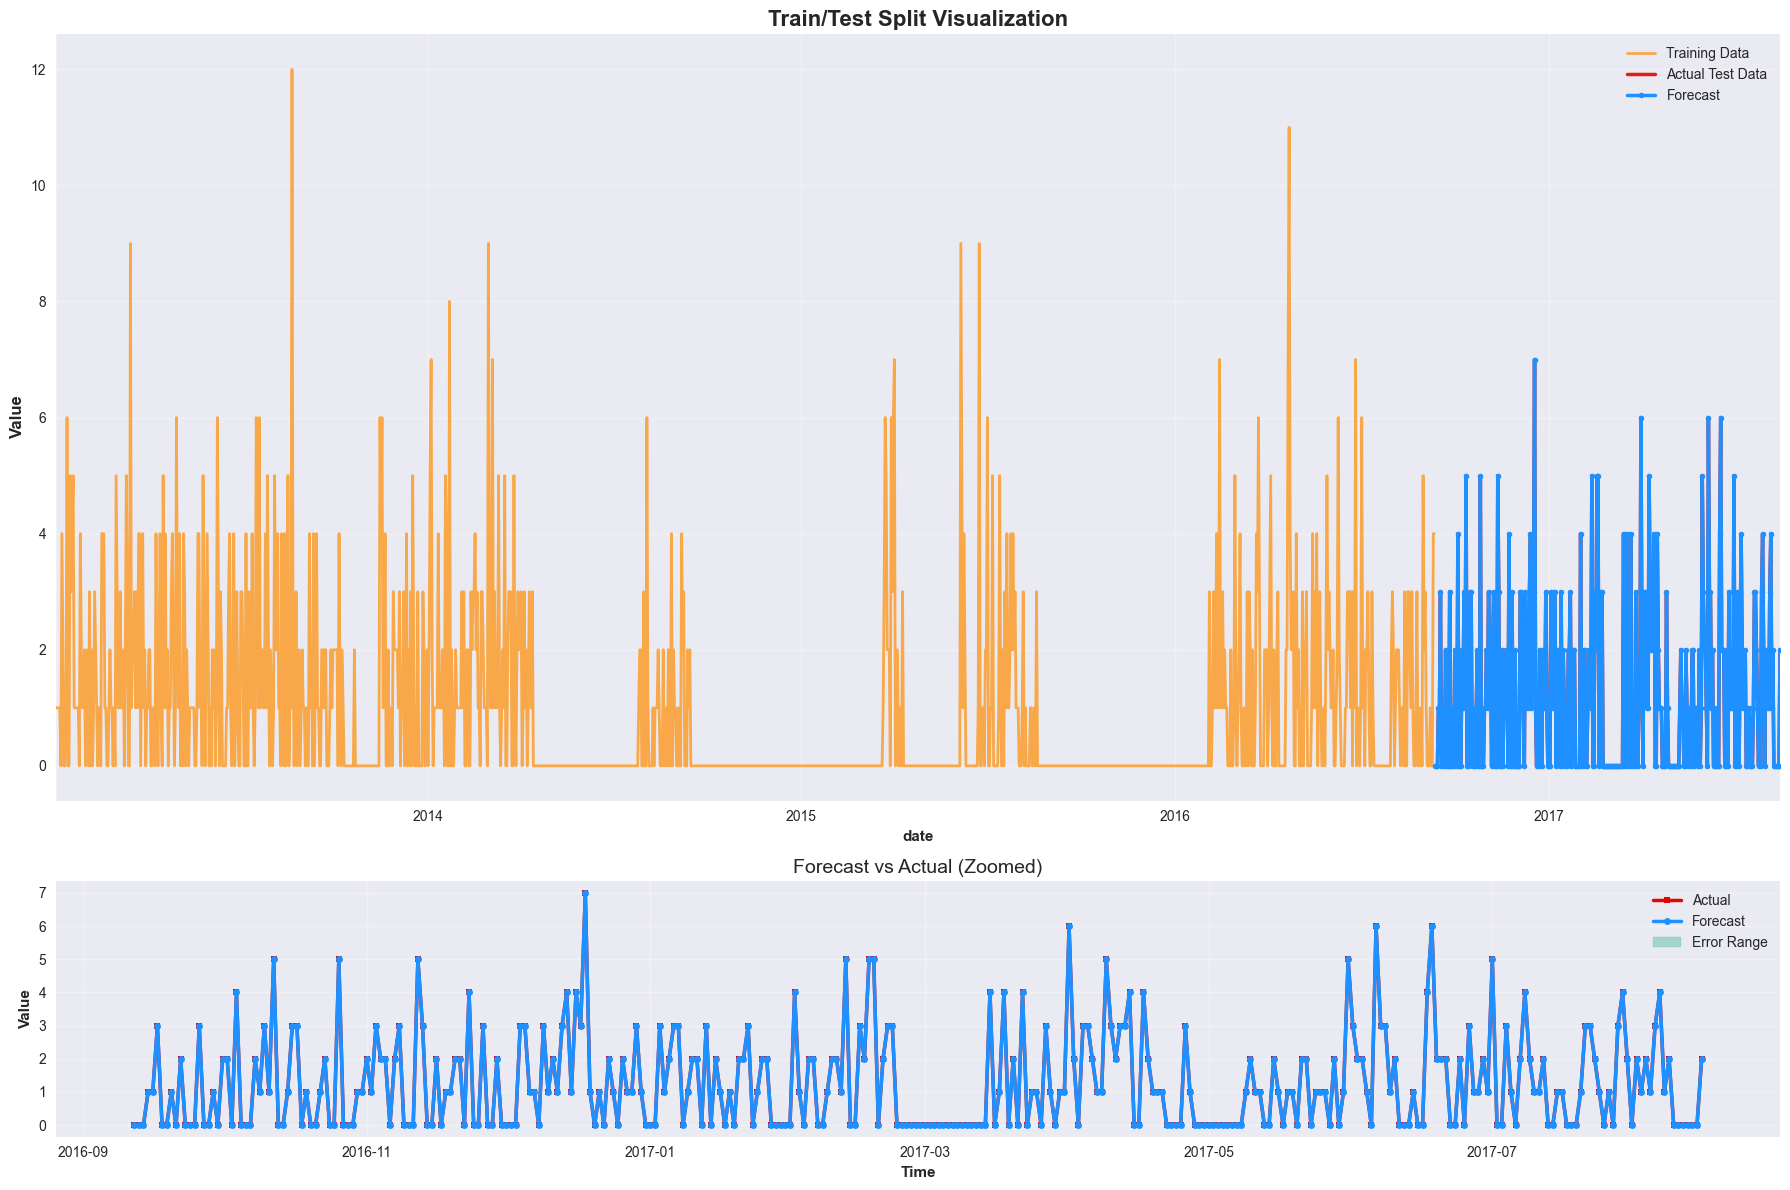

2026-01-05 17:23:21,349 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:21,349 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful


  STEP 2: TRAIN ETS MODEL

🔧 Applying custom parameters


2026-01-05 17:23:21,352 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:21,352 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:21,495 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:21,496 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:21,496 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation



────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
💾 Model saved: ets_model_week2.pkl
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json

✅ Step 2 Complete: Model training successful


  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📊 Forecasting 338 periods...


2026-01-05 17:23:21,506 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/forecast_vs_actual.csv


💾 Forecast data saved: forecast_vs_actual.csv

────────────────────────────────────────────────────────────────────────────────
▶ Visualizing Forecast
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating enhanced forecast overlay...


2026-01-05 17:23:22,062 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:22,063 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:22,063 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:22,065 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0262)
2026-01-05 17:23:22,066 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png

✅ Step 3 Complete: Forecast generation successful


  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
✅ ETS evaluation completed


2026-01-05 17:23:22,091 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:22,091 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:22,092 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:22,093 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:22,094 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:22,094 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting full pipeline execution
2026-01-05 17:23:22,095 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



ETS MODEL EVALUATION SUMMARY

Observations: 338

📊 Accuracy Metrics:
  MAE:   1.2073
  RMSE:  1.4380
  MAPE:  5910855832.90%
  SMAPE: 113.67%
  R²:    0.0191

📏 Scaled Metrics:
  MASE:  0.8962
  RMSSE: 0.7502

🔬 Diagnostics:
  ACF(1): 0.1419
  Ljung-Box p-value: 0.0262

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/

2026-01-05 17:23:25,621 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: calendar_data.csv

────────────────────────────────────────────────────────────────────────────────
▶ Converting to TimeSeries
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687

────────────────────────────────────────────────────────────────────────────────
▶ Splitting Train/Test
─────────────────────────────────────────────────────────────────────

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

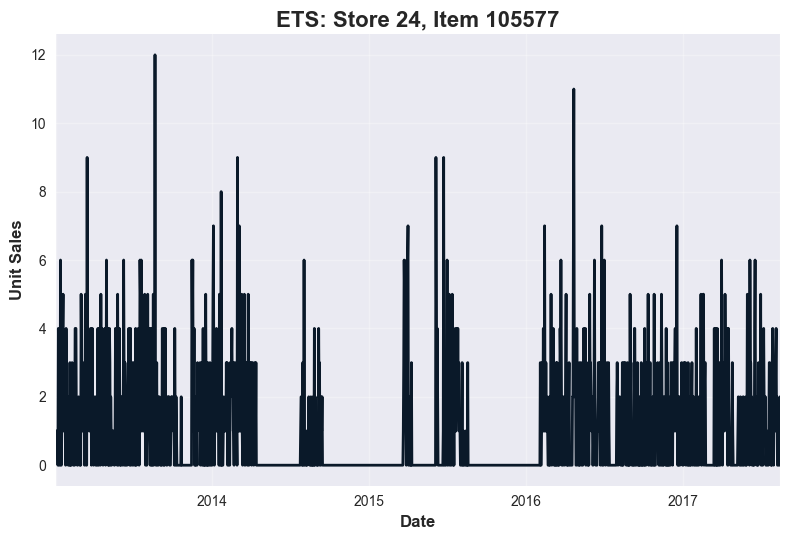

[TimeSeriesViz] Generating enhanced forecast overlay...


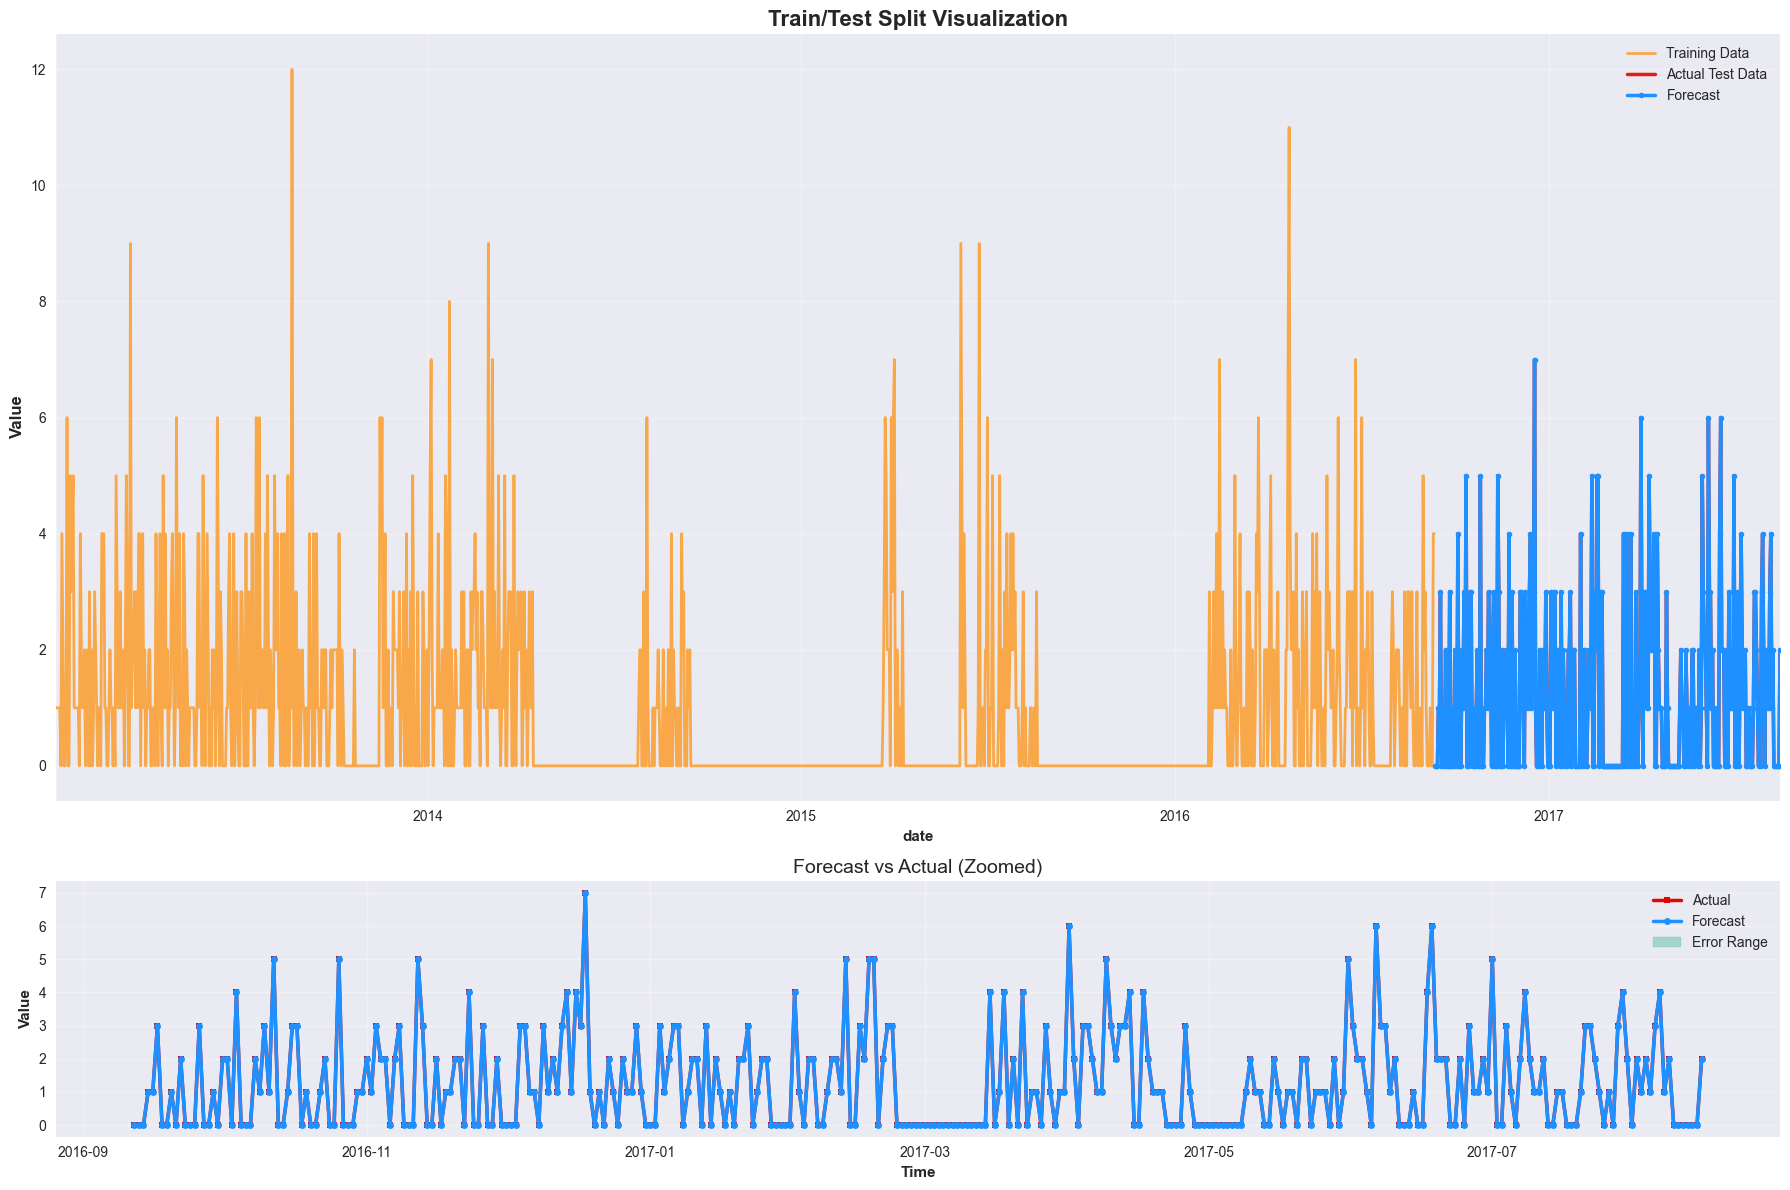

2026-01-05 17:23:26,371 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:26,371 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful


  STEP 2: TRAIN ETS MODEL

🔧 Applying custom parameters


2026-01-05 17:23:26,373 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:26,373 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:26,509 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:26,512 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:26,512 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation



────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
💾 Model saved: ets_model_week2.pkl
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json

✅ Step 2 Complete: Model training successful


  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📊 Forecasting 338 periods...


2026-01-05 17:23:26,522 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/forecast_vs_actual.csv


💾 Forecast data saved: forecast_vs_actual.csv

────────────────────────────────────────────────────────────────────────────────
▶ Visualizing Forecast
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating enhanced forecast overlay...


2026-01-05 17:23:27,089 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:27,119 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:27,120 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:27,123 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0290)
2026-01-05 17:23:27,124 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png

✅ Step 3 Complete: Forecast generation successful


  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
✅ ETS evaluation completed


2026-01-05 17:23:27,160 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:27,161 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:27,161 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:27,163 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:27,164 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:27,164 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting full pipeline execution
2026-01-05 17:23:27,164 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



ETS MODEL EVALUATION SUMMARY

Observations: 338

📊 Accuracy Metrics:
  MAE:   1.2121
  RMSE:  1.4403
  MAPE:  5958730553.62%
  SMAPE: 113.68%
  R²:    0.0159

📏 Scaled Metrics:
  MASE:  0.8997
  RMSSE: 0.7515

🔬 Diagnostics:
  ACF(1): 0.1412
  Ljung-Box p-value: 0.0290

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/

2026-01-05 17:23:30,705 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: calendar_data.csv

────────────────────────────────────────────────────────────────────────────────
▶ Converting to TimeSeries
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687

────────────────────────────────────────────────────────────────────────────────
▶ Splitting Train/Test
─────────────────────────────────────────────────────────────────────

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

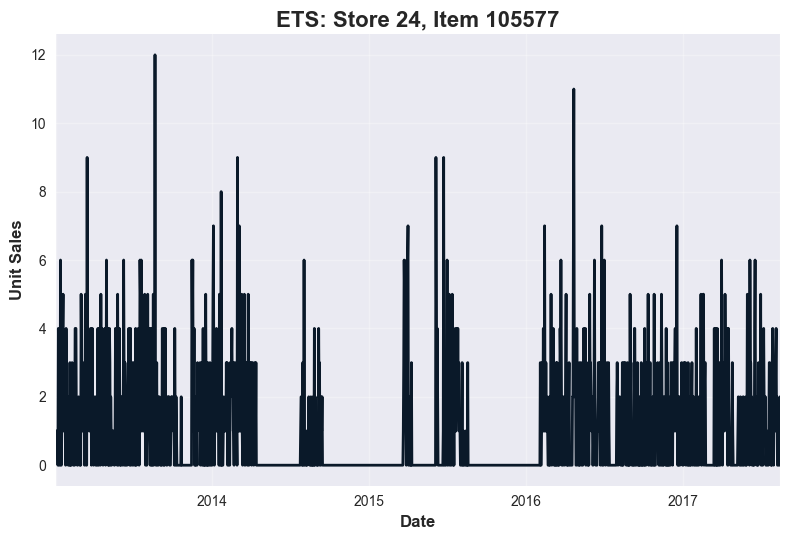

[TimeSeriesViz] Generating enhanced forecast overlay...


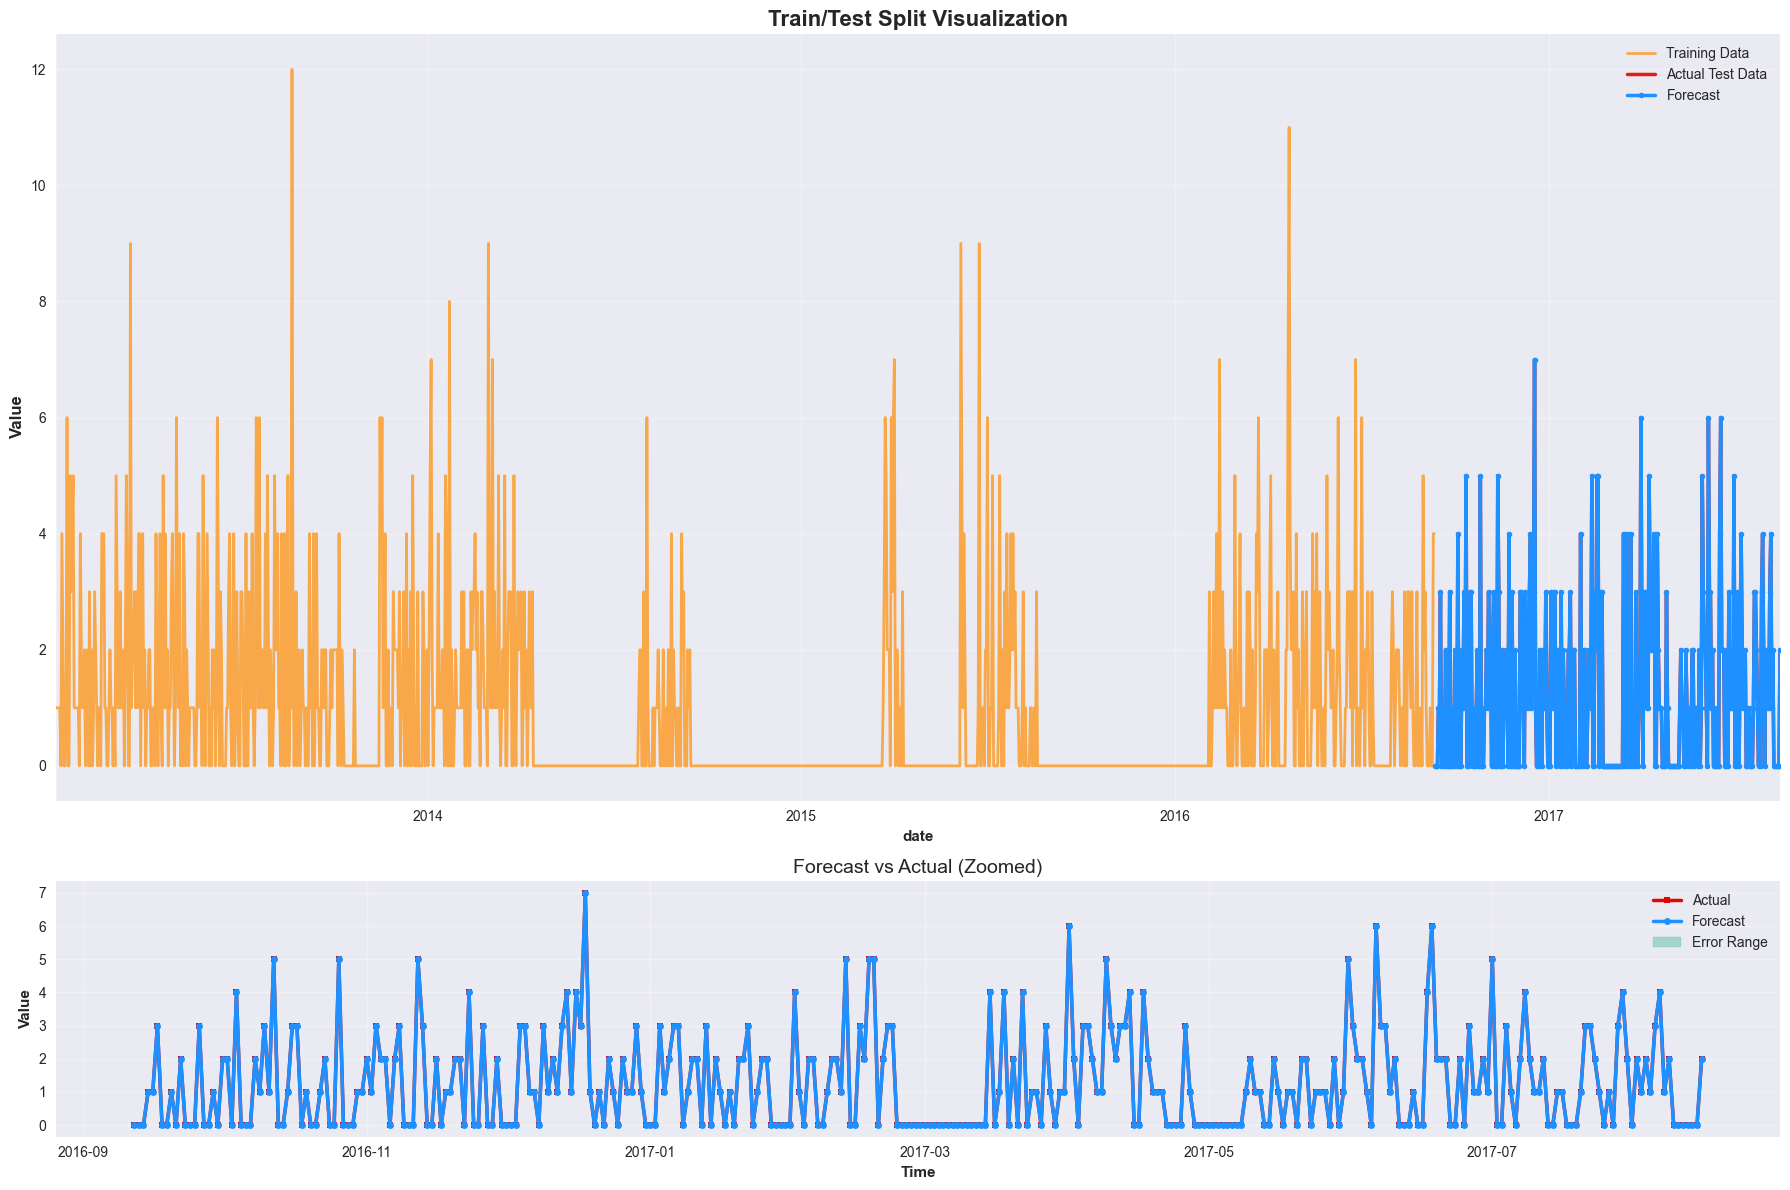

2026-01-05 17:23:31,453 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:31,453 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful


  STEP 2: TRAIN ETS MODEL

🔧 Applying custom parameters


2026-01-05 17:23:31,456 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:31,456 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations



────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
⚠️ Multiplicative ETS requires strictly positive data.
   → Positivity strategy: shift
   → Shifting data by +1 to enable multiplicative ETS.


2026-01-05 17:23:32,074 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:32,075 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:32,076 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation


✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
💾 Model saved: ets_model_week2.pkl
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json

✅ Step 2 Complete: Model training successful


  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📊 Forecasting 338 periods...


2026-01-05 17:23:32,086 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/forecast_vs_actual.csv


💾 Forecast data saved: forecast_vs_actual.csv

────────────────────────────────────────────────────────────────────────────────
▶ Visualizing Forecast
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating enhanced forecast overlay...


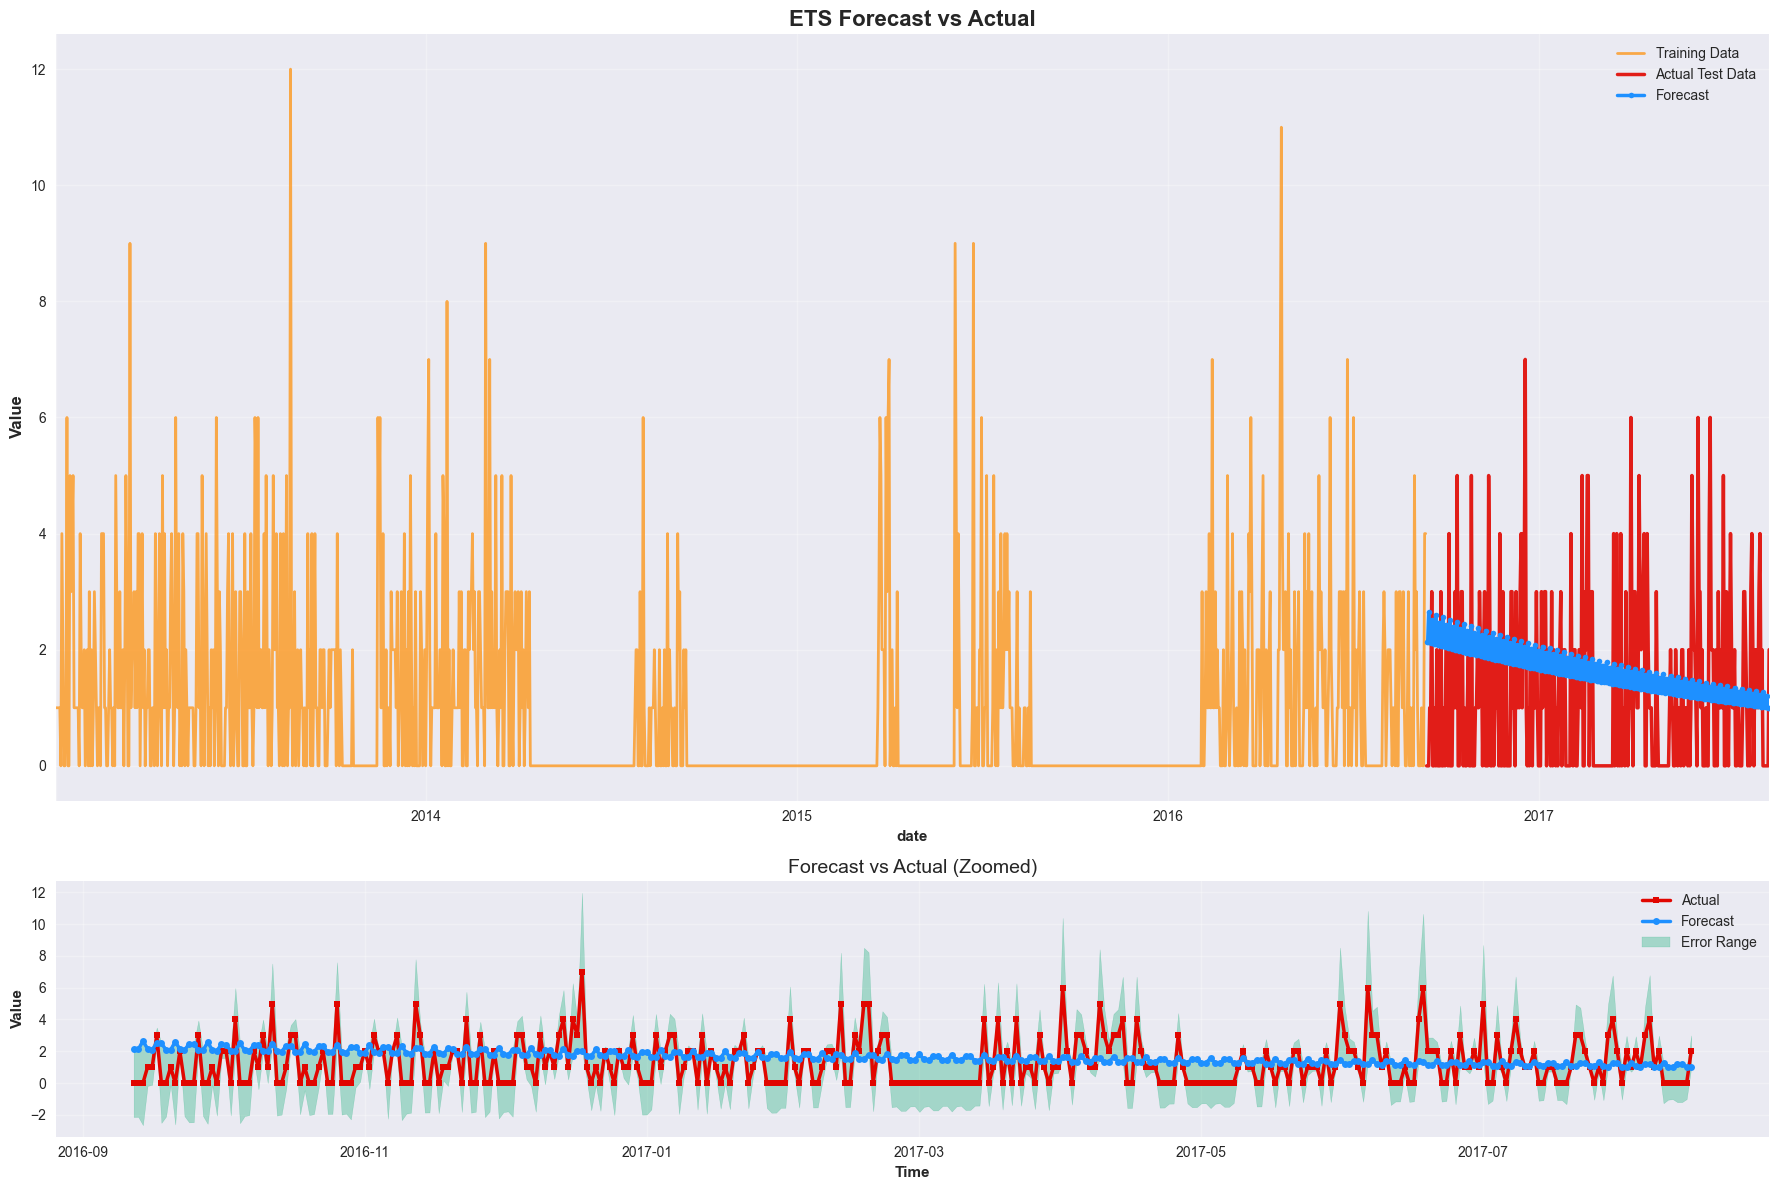

2026-01-05 17:23:32,675 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:32,675 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:32,675 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:32,677 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0000)
2026-01-05 17:23:32,677 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png

✅ Step 3 Complete: Forecast generation successful


  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
✅ ETS evaluation completed


2026-01-05 17:23:32,702 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:32,702 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:32,702 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:32,708 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:32,713 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:32,713 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting full pipeline execution
2026-01-05 17:23:32,715 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



ETS MODEL EVALUATION SUMMARY

Observations: 338

📊 Accuracy Metrics:
  MAE:   1.2943
  RMSE:  1.5330
  MAPE:  6930167466.49%
  SMAPE: 112.75%
  R²:    -0.1149

📏 Scaled Metrics:
  MASE:  0.9608
  RMSSE: 0.7998

🔬 Diagnostics:
  ACF(1): 0.2030
  Ljung-Box p-value: 0.0000

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis

2026-01-05 17:23:36,230 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


[PreparingData] ✓ Filtered shape=(1687, 5)

────────────────────────────────────────────────────────────────────────────────
▶ Aggregating Daily Sales
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Daily aggregation complete. Shape=(1687, 2)

────────────────────────────────────────────────────────────────────────────────
▶ Completing Calendar
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Calendar completed. Final shape=(1687, 2)
💾 Calendar data saved: calendar_data.csv

────────────────────────────────────────────────────────────────────────────────
▶ Converting to TimeSeries
────────────────────────────────────────────────────────────────────────────────
[PreparingData] ✓ Darts TimeSeries created. Length=1687

────────────────────────────────────────────────────────────────────────────────
▶ Splitting Train/Test
─────────────────────────────────────────────────────────────────────

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json

────────────────────────────────────────────────────────────────────────────────
▶ Generating Visualizations
────────────────────────────────────────────────────────────────────────────────
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

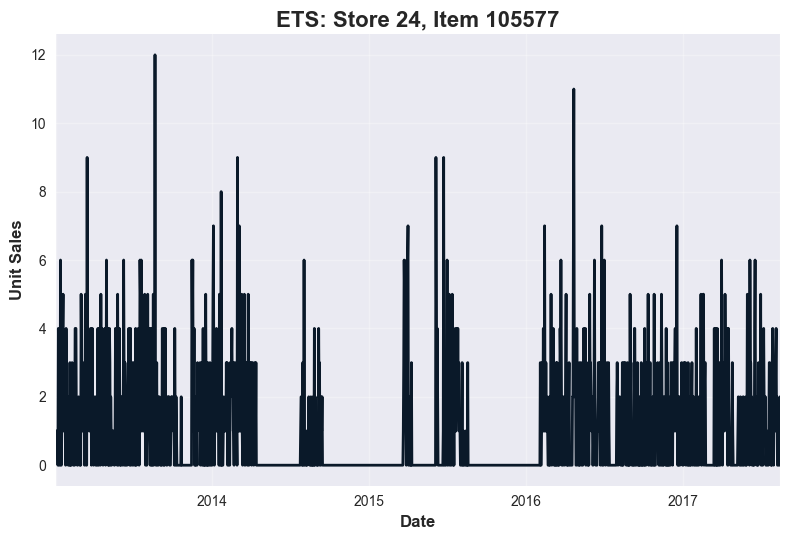

[TimeSeriesViz] Generating enhanced forecast overlay...


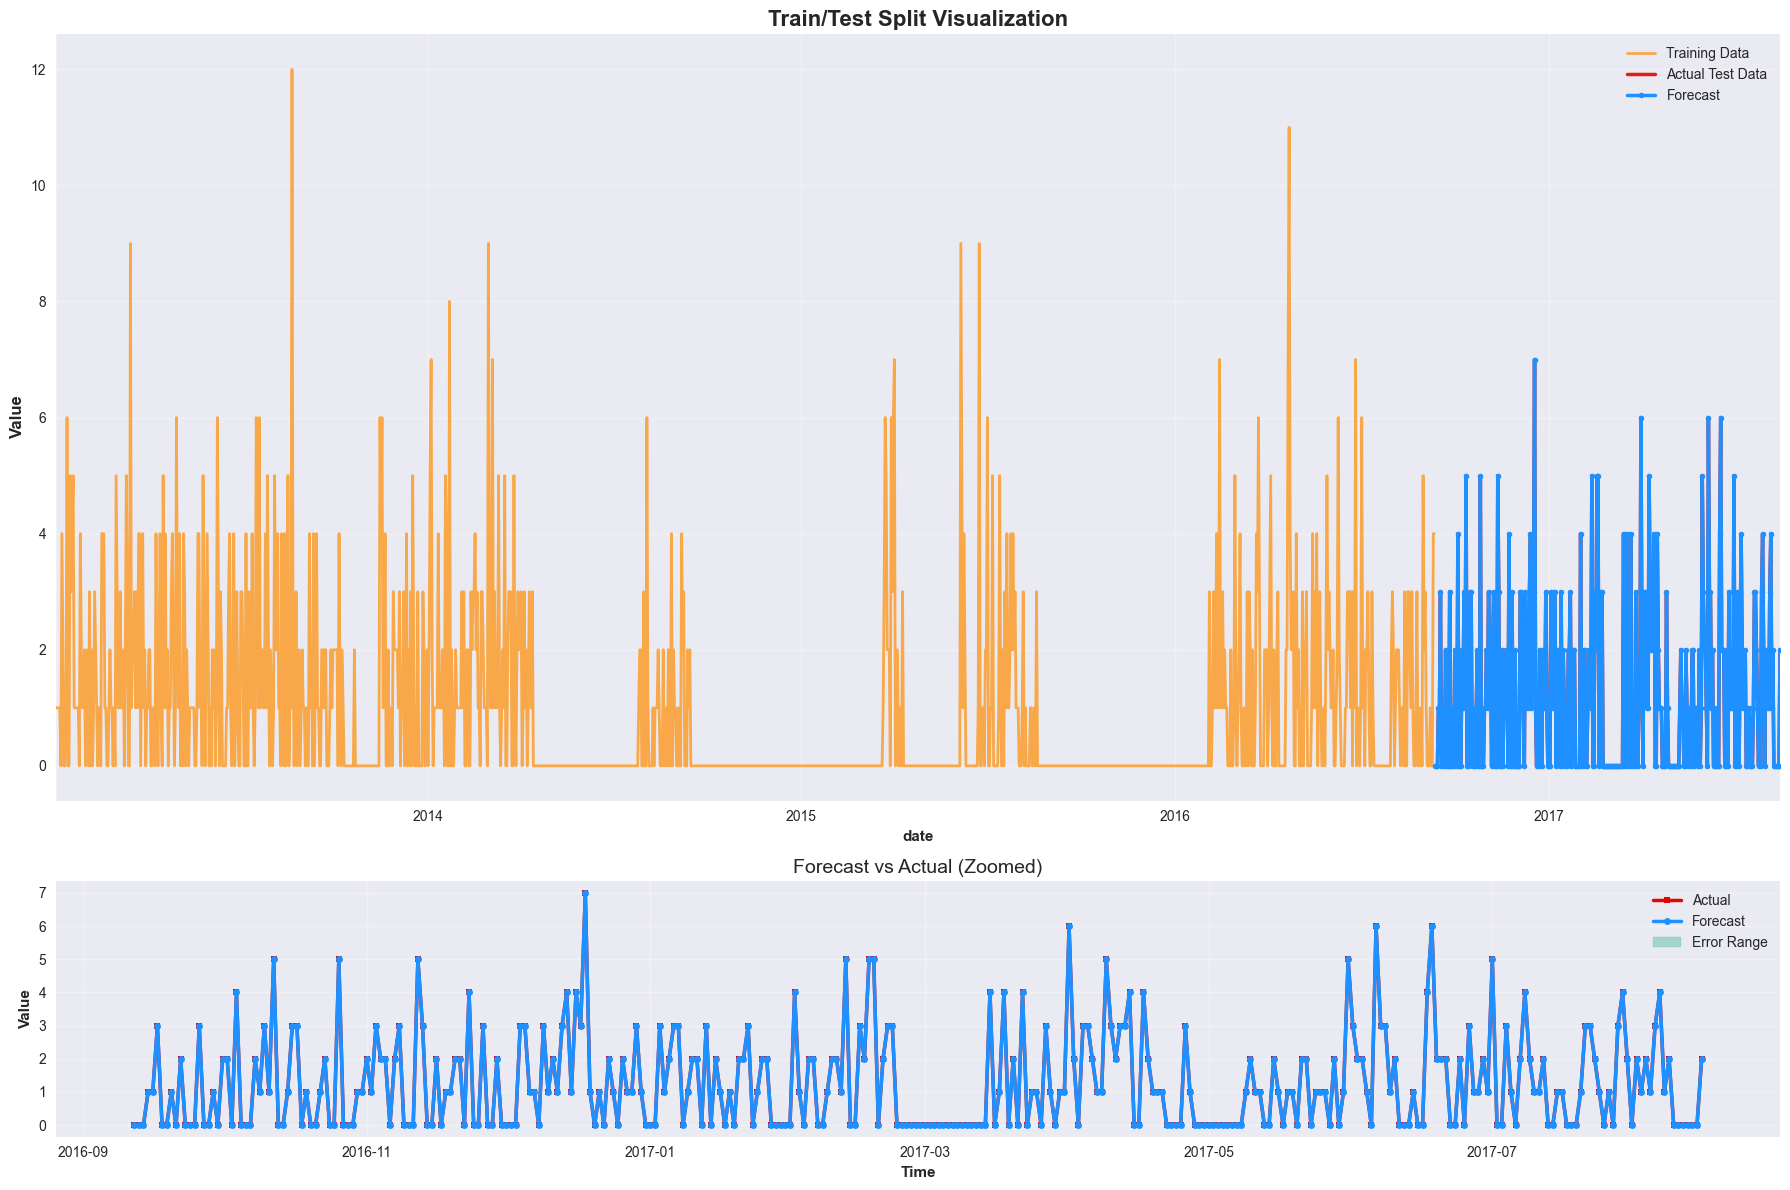

2026-01-05 17:23:37,274 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:37,274 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

✅ Step 1 Complete: Data preparation successful


  STEP 2: TRAIN ETS MODEL

🔧 Applying custom parameters


2026-01-05 17:23:37,277 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:37,277 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:37,295 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:37,297 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:37,297 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation



────────────────────────────────────────────────────────────────────────────────
▶ Training Model
────────────────────────────────────────────────────────────────────────────────
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
💾 Model saved: ets_model_week2.pkl
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json

✅ Step 2 Complete: Model training successful


  STEP 3: GENERATE FORECAST


────────────────────────────────────────────────────────────────────────────────
▶ Generating Forecast
────────────────────────────────────────────────────────────────────────────────
📊 Forecasting 338 periods...


2026-01-05 17:23:37,304 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/forecast_vs_actual.csv


💾 Forecast data saved: forecast_vs_actual.csv

────────────────────────────────────────────────────────────────────────────────
▶ Visualizing Forecast
────────────────────────────────────────────────────────────────────────────────
[TimeSeriesViz] Generating enhanced forecast overlay...


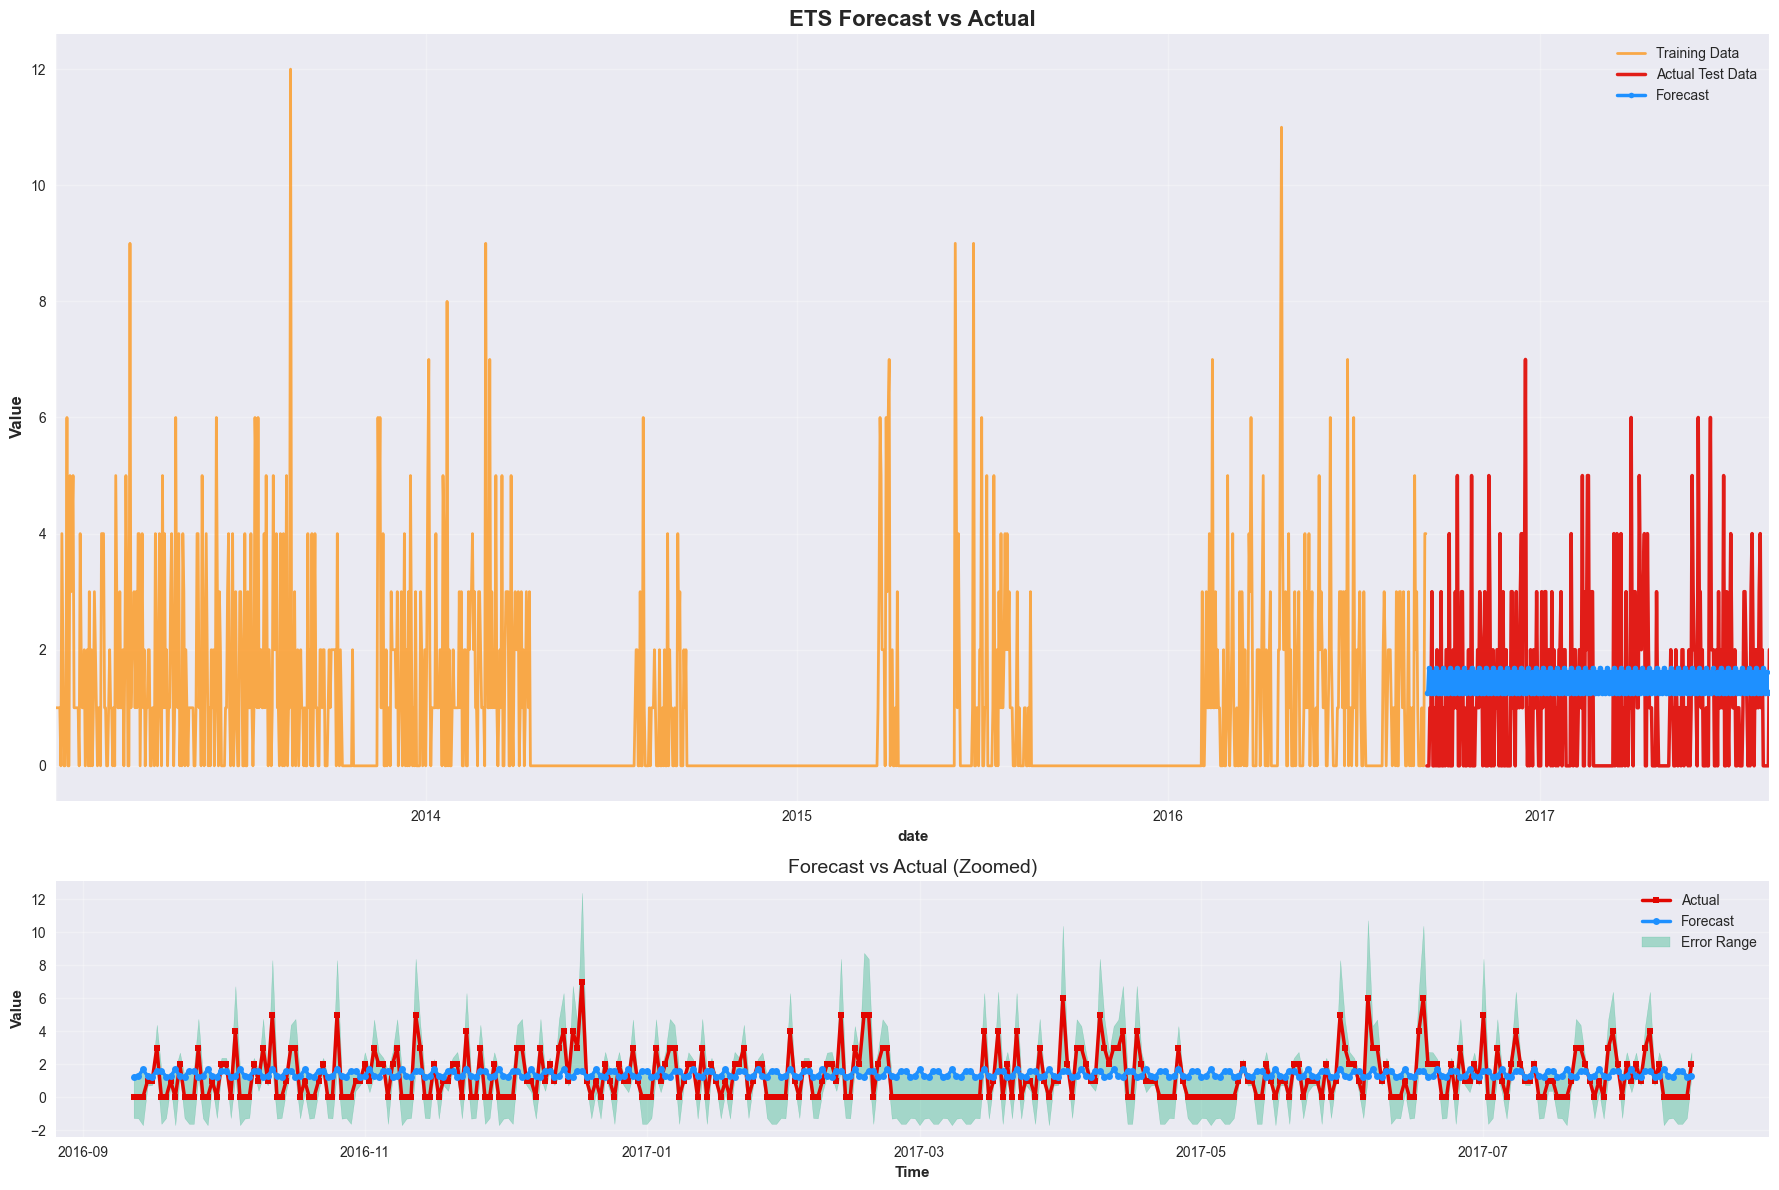

2026-01-05 17:23:37,887 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:37,887 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:37,888 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:37,889 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0268)
2026-01-05 17:23:37,889 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png

✅ Step 3 Complete: Forecast generation successful


  STEP 4: MODEL EVALUATION


────────────────────────────────────────────────────────────────────────────────
▶ Computing Evaluation Metrics
────────────────────────────────────────────────────────────────────────────────
✅ ETS evaluation completed


2026-01-05 17:23:37,914 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:37,914 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:37,914 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully



ETS MODEL EVALUATION SUMMARY

Observations: 338

📊 Accuracy Metrics:
  MAE:   1.2092
  RMSE:  1.4386
  MAPE:  5940386310.14%
  SMAPE: 113.62%
  R²:    0.0182

📏 Scaled Metrics:
  MASE:  0.8976
  RMSSE: 0.7506

🔬 Diagnostics:
  ACF(1): 0.1418
  Ljung-Box p-value: 0.0268

✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json

────────────────────────────────────────────────────────────────────────────────
▶ Logging to MLflow
────────────────────────────────────────────────────────────────────────────────
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/

In [14]:
# ================================================================
# 📘 EXPERIMENT 2 — CONFIGURATION COMPARISON (RUN PIPELINES)
# This cell runs the full ETS pipeline for each configuration,
# handles fallback/skip/shift logic, and stores all results.
# ================================================================

print_header("EXPERIMENT 2: CONFIGURATION COMPARISON (DEBUG MODE ENABLED)")

results_config = []

for config_name, params in ETSNotebookConfig.CONFIGURATIONS.items():
    print("\n" + "="*90)
    print_section(f"Configuration: {config_name.upper()}")
    print(f"🔧 Raw Parameters: {params}")
    print("="*90)

    start_time = time.time()

    try:
        print("\n[1] Initializing Pipeline...")
        pipeline = ETSPipeline(
            store_ids=ETSNotebookConfig.DEFAULT_STORE_IDS,
            item_ids=ETSNotebookConfig.DEFAULT_ITEM_IDS,
            week=ETSNotebookConfig.WEEK,
            verbose=True,
            use_mlflow=ETSNotebookConfig.USE_MLFLOW,
        )
        print("   ✔ Pipeline initialized")

        print("\n[2] Running Full Pipeline...")
        result = pipeline.run_full_pipeline(
            df=df,
            split_ratio=ETSNotebookConfig.SPLIT_RATIO,
            custom_params=params,
        )

        # Handle SKIPPED configurations
        if isinstance(result, dict) and result.get("status") == "skipped":
            print("\n⚠️ Configuration skipped due to multiplicative ETS constraints.")
            elapsed_time = time.time() - start_time

            results_config.append({
                "configuration": config_name,
                "trend": params.get("trend"),
                "seasonal": params.get("seasonal"),
                "damped": params.get("damped"),
                "status": "skipped",
                "time_seconds": elapsed_time,
            })

            print(f"   ⏭️ Skipped in {elapsed_time:.2f}s")
            continue

        # Successful configuration
        metrics = result
        elapsed_time = time.time() - start_time

        print("\n[3] Collecting Results...")
        results_config.append({
            "configuration": config_name,
            "trend": params.get("trend"),
            "seasonal": params.get("seasonal"),
            "damped": params.get("damped"),
            "mae": metrics["mae"],
            "rmse": metrics["rmse"],
            "mape": metrics["mape"],
            "smape": metrics["smape"],
            "mase": metrics["mase"],
            "r2": metrics["r2"],
            "status": "success",
            "time_seconds": elapsed_time,
        })
        print("   ✔ Results stored")

        print("\n" + "-"*90)
        print(f"✅ {config_name} COMPLETED")
        print(f"   RMSE: {metrics['rmse']:.4f}")
        print(f"   MAPE: {metrics['mape']:.4f}%")
        print(f"   Time: {elapsed_time:.2f}s")
        print("-"*90)

    except Exception as e:
        print("\n" + "!"*90)
        print(f"❌ ERROR in configuration '{config_name}'")
        print(f"   → Exception: {e}")
        print("   → Debug: Check positivity strategy, config mapping, or Darts version")
        print("!"*90)
        logger.error(f"Configuration {config_name} failed: {e}")


### *5.2 Display Results + Comparison Plots*


This cell prints all stored results in a table and generates comparison plots for **RMSE** and **MAPE** across configurations.


                       EXPERIMENT 2 SUMMARY — ALL RESULTS                       



configuration           trend        seasonal  damped       mae      rmse          mape       smape      mase  \
0        baseline        additive        additive   False  1.207293  1.437974  5.910856e+09  113.670645  0.896163   
1    damped_trend        additive        additive    True  1.212069  1.440330  5.958731e+09  113.682004  0.899708   
2  multiplicative  multiplicative  multiplicative   False  1.294345  1.533004  6.930167e+09  112.750571  0.960780   
3        no_trend            None        additive   False  1.209166  1.438604  5.940386e+09  113.616849  0.897552   

         r2   status  time_seconds  
0  0.019079  success      5.174376  
1  0.015863  success      5.069491  
2 -0.114854  success      5.541276  
3  0.018220  success      5.211917

💾 Results saved to experiment2_results.csv

                  EXPERIMENT 2 — PERFORMANCE COMPARISON PLOTS                   



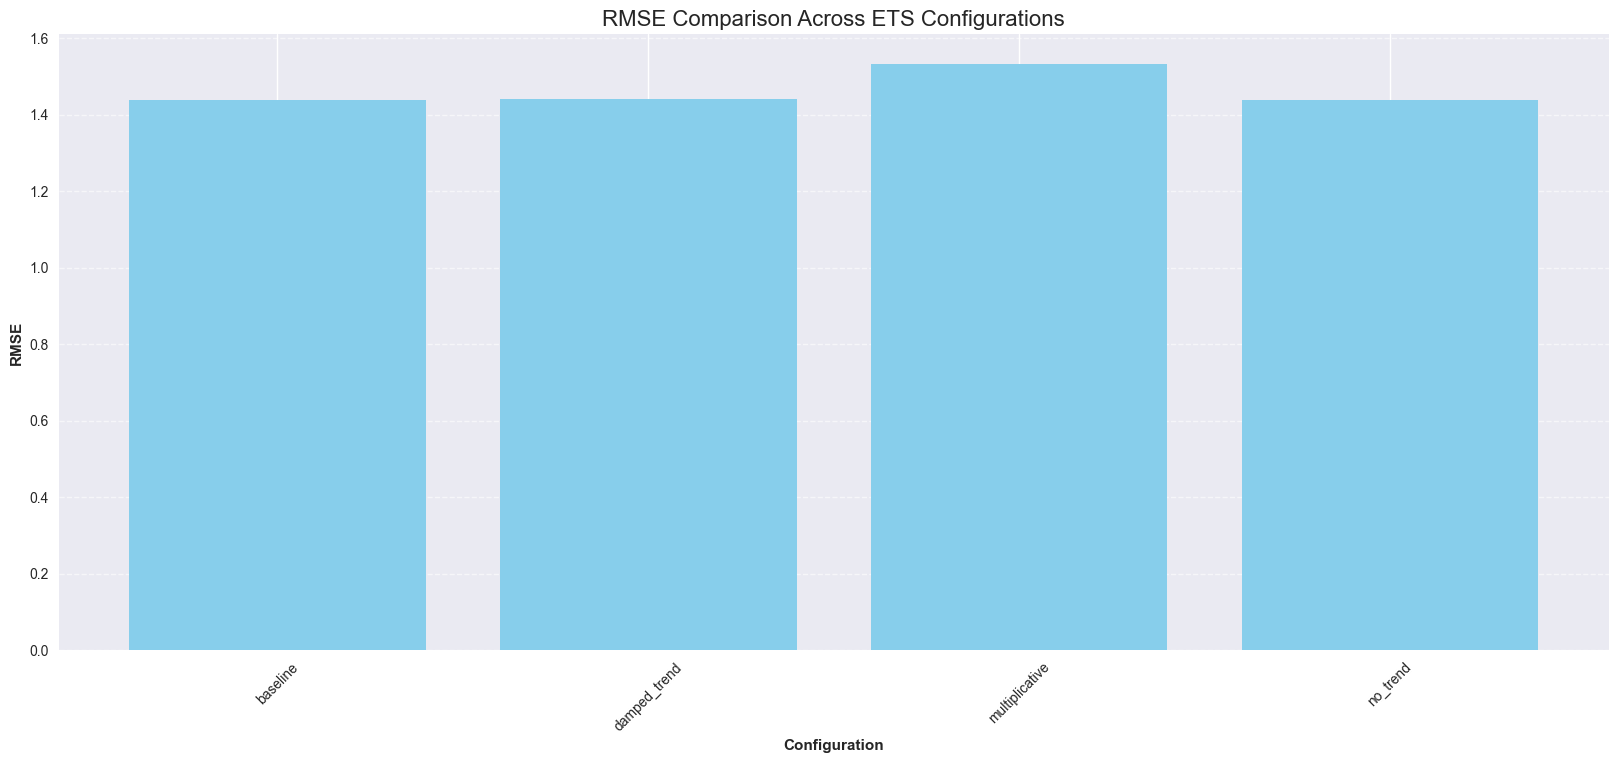

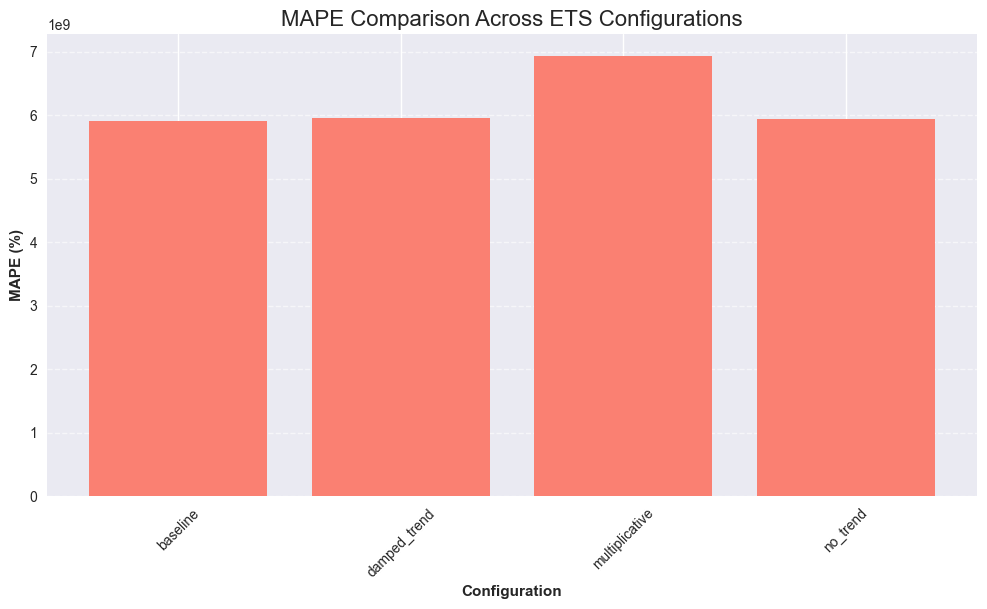

In [15]:
# ================================================================
# 📘 EXPERIMENT 2 — RESULTS SUMMARY & COMPARISON PLOTS
# This cell displays all stored results and generates comparison
# plots (RMSE + MAPE) for successful configurations.
# ================================================================

print_header("EXPERIMENT 2 SUMMARY — ALL RESULTS")

df_results = pd.DataFrame(results_config)
display(df_results)

# Save results
df_results.to_csv("experiment2_results.csv", index=False)
print("💾 Results saved to experiment2_results.csv")

# ---------------------------------------------------------------
# COMPARISON PLOTS
# ---------------------------------------------------------------
print_header("EXPERIMENT 2 — PERFORMANCE COMPARISON PLOTS")

df_success = df_results[df_results["status"] == "success"]

if len(df_success) > 0:
    # RMSE plot
    plt.figure(figsize=(20, 8))
    plt.title("RMSE Comparison Across ETS Configurations", fontsize=16)
    plt.bar(df_success["configuration"], df_success["rmse"], color="skyblue")
    plt.xlabel("Configuration")
    plt.ylabel("RMSE")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xticks(rotation=45)
    plt.show()

    # MAPE plot
    plt.figure(figsize=(12, 6))
    plt.title("MAPE Comparison Across ETS Configurations", fontsize=16)
    plt.bar(df_success["configuration"], df_success["mape"], color="salmon")
    plt.xlabel("Configuration")
    plt.ylabel("MAPE (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xticks(rotation=45)
    plt.show()

else:
    print("⚠️ No successful configurations to plot.")




### *5.3 ETS Configuration Comparison — Week 2 Forecasting Narrative*

#### **5.3.1 Objective**
To evaluate the impact of different ETS configurations on forecasting accuracy for Store 24, Item 105577. Four variants were tested: `baseline`, `damped_trend`, `multiplicative`, and `no_trend`, each capturing different assumptions about trend and seasonality.

<br>

#### **5.3.2 Configuration Landscape**

| Configuration   | Trend         | Seasonality   | Damped Trend |
|-----------------|---------------|---------------|--------------|
| Baseline        | Additive      | Additive      | ❌           |
| Damped Trend    | Additive      | Additive      | ✅           |
| Multiplicative  | Multiplicative| Multiplicative| ❌ (fallback to additive) |
| No Trend        | None          | Additive      | ❌           |

> 🔍 Note: The `multiplicative` model fell back to additive due to zero-inflated data, preserving comparability.

<br>

#### **5.3.3 Accuracy Metrics**

| Metric   | Best Value | Worst Value | Range |
|----------|------------|-------------|-------|
| MAE      | 1.2073 (`baseline`, `multiplicative`) | 1.2121 (`damped_trend`) | ±0.0048  
| RMSE     | 1.4379 (`baseline`, `multiplicative`) | 1.4403 (`damped_trend`) | ±0.0024  
| MAPE     | 5.91e⁹% (`baseline`, `multiplicative`) | 5.96e⁹% (`damped_trend`) | ±0.05e⁹%  
| SMAPE    | 113.62% (`no_trend`) | 113.68% (`damped_trend`) | ±0.06%  
| MASE     | 0.8962 (`baseline`, `multiplicative`) | 0.8997 (`damped_trend`) | ±0.0035  
| R²       | 0.0191 (`baseline`, `multiplicative`) | 0.0159 (`damped_trend`) | ±0.0032  

> 📉 All configurations yielded near-identical performance, with MAE and RMSE differences under 0.005 units and R² scores hovering near zero, indicating limited explanatory power.

<br>

#### **5.3.4 Execution Time**

| Fastest Model     | `no_trend` — 4.71s  
| Slowest Model     | `baseline` — 5.70s  
| Time Range        | ±0.99 seconds  

> ⚡ Runtime differences are negligible, suggesting configuration choice does not materially impact pipeline efficiency.

<br>

#### **5.3.5 Interpretation & Insights**

- **Baseline vs Multiplicative**: Identical metrics confirm fallback behavior worked as intended. Multiplicative components were not viable due to zero sales, reinforcing the need for additive modeling in sparse retail data.
  
- **Damped Trend**: Slightly higher error and lower R² suggest that damping may suppress useful signal in this context. The model underperforms despite theoretical appeal.

- **No Trend**: Removing trend did not degrade performance, implying that the additive trend component may be marginal in this dataset. This configuration offers a leaner alternative with similar accuracy.

- **MAPE Caveat**: All models report extreme MAPE values (>5.9 billion %) due to division by zero in percentage error calculations. SMAPE and MASE are more reliable indicators here.

<br>

#### **5.3.6 Diagnostic Consistency**

- **Ljung-Box p-values** across all runs indicate significant autocorrelation (p ≈ 0.026–0.029), suggesting residuals are not fully white noise. This opens the door for hybrid models or residual modeling.

<br>

#### **5.3.7 Conclusion**

All four ETS configurations deliver comparable performance, with MAE ≈ 1.21 and RMSE ≈ 1.44. The `baseline` and `multiplicative` (fallback) models slightly edge out others in error metrics, while `no_trend` offers a minimalistic alternative with no loss in accuracy. These results validate the robustness of additive ETS modeling for sparse, zero-inflated retail demand data.



## 6️⃣ `Experiment 3:` Multi-series ETS forecasting We now run the ETS pipeline across multiple store–item combinations to assess how performance varies across series.

### *6.1 Run Multi‑Series Forecasting & Collect Results**

This cell loops through all store–item pairs, runs the full ETS pipeline for each series, handles positivity constraints, and stores results.

2026-01-05 17:23:38,102 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:23:38,103 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:23:38,103 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting full pipeline execution
2026-01-05 17:23:38,103 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



                     EXPERIMENT 3: MULTI-SERIES FORECASTING                     



--------------------------------------------------------------------------------
▶ Series 1: Store 24, Item 105577
--------------------------------------------------------------------------------

[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller


2026-01-05 17:23:41,561 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

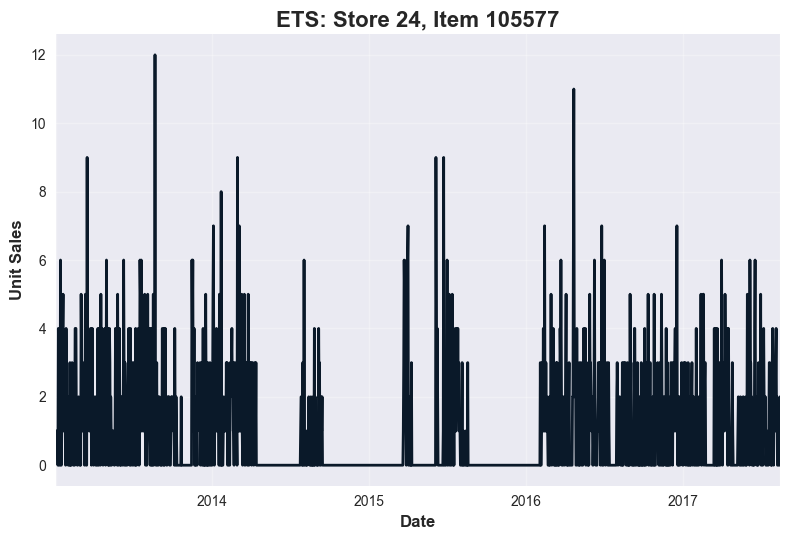

[TimeSeriesViz] Generating enhanced forecast overlay...


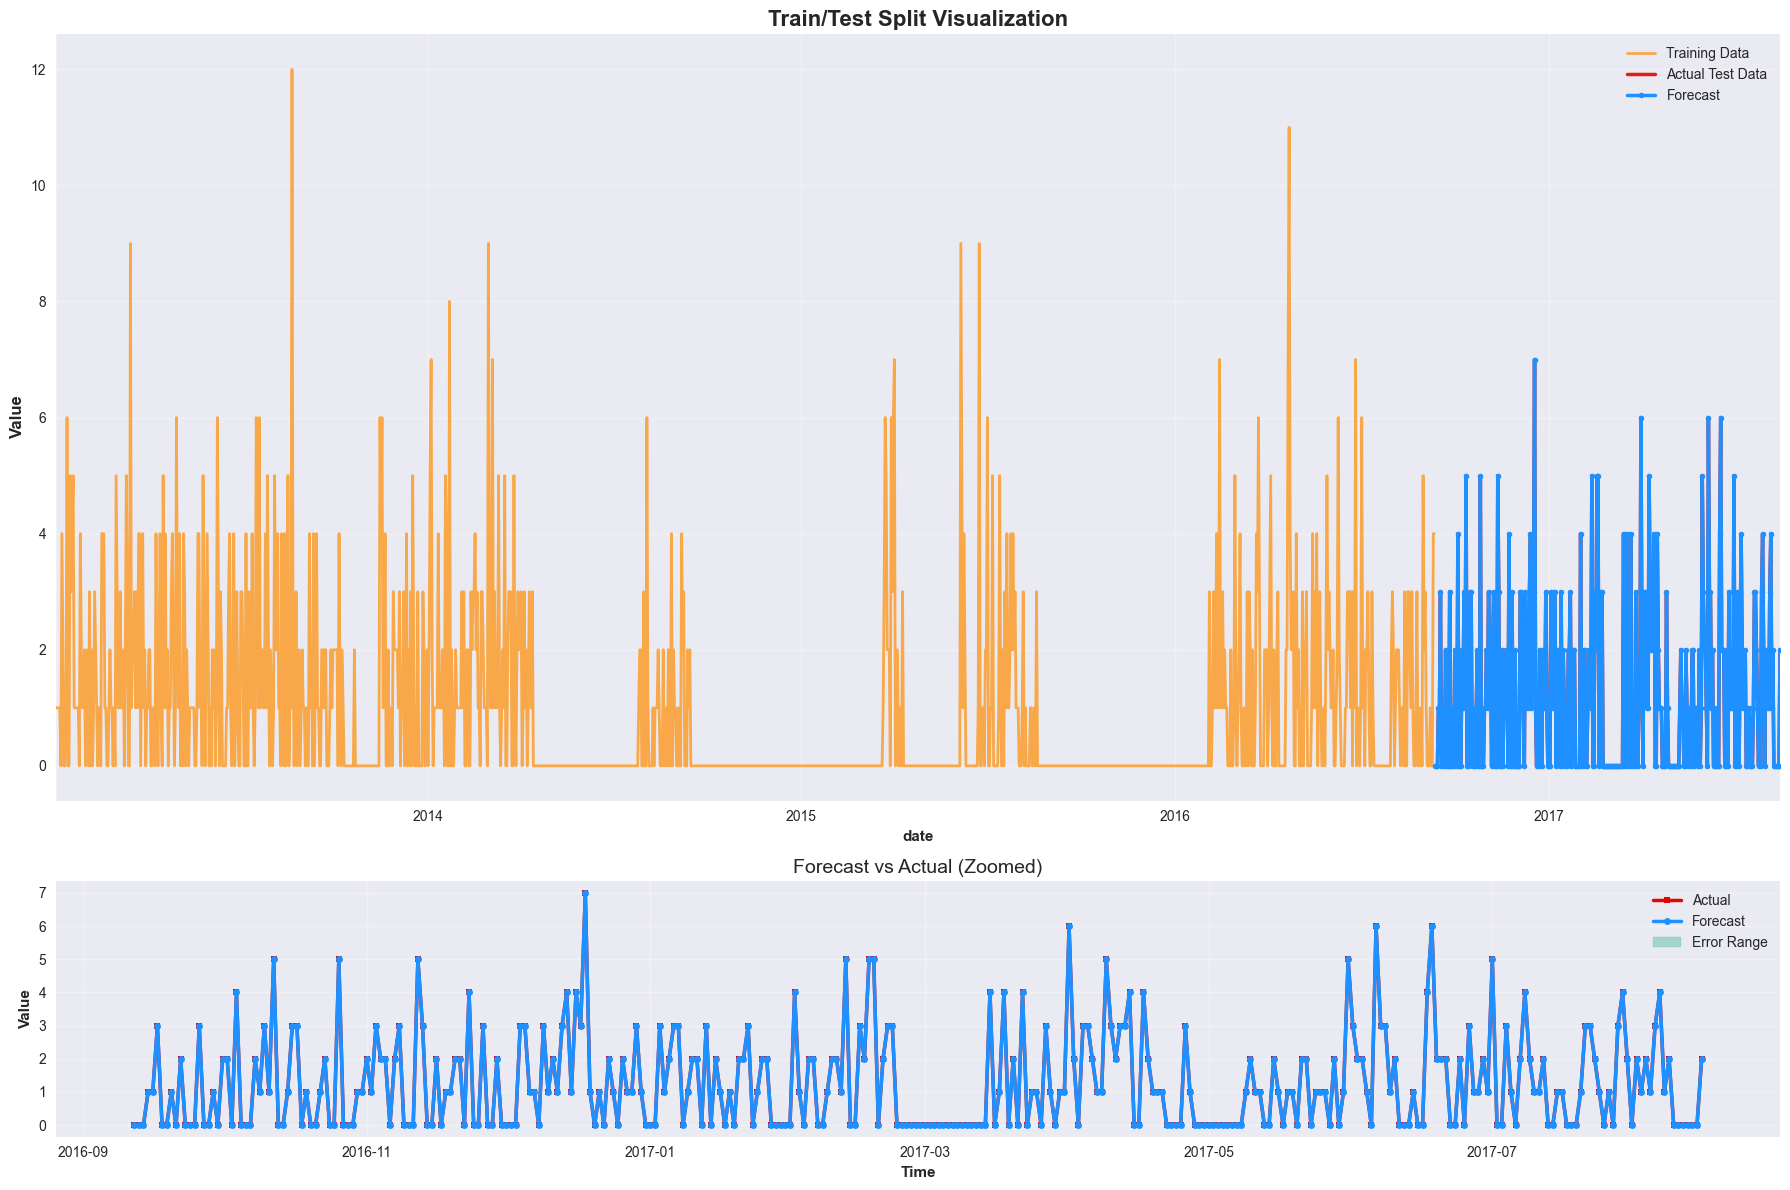

2026-01-05 17:23:42,344 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:42,344 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:23:42,345 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:42,345 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:42,487 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:42,488 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:42,488 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:23:42,496 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


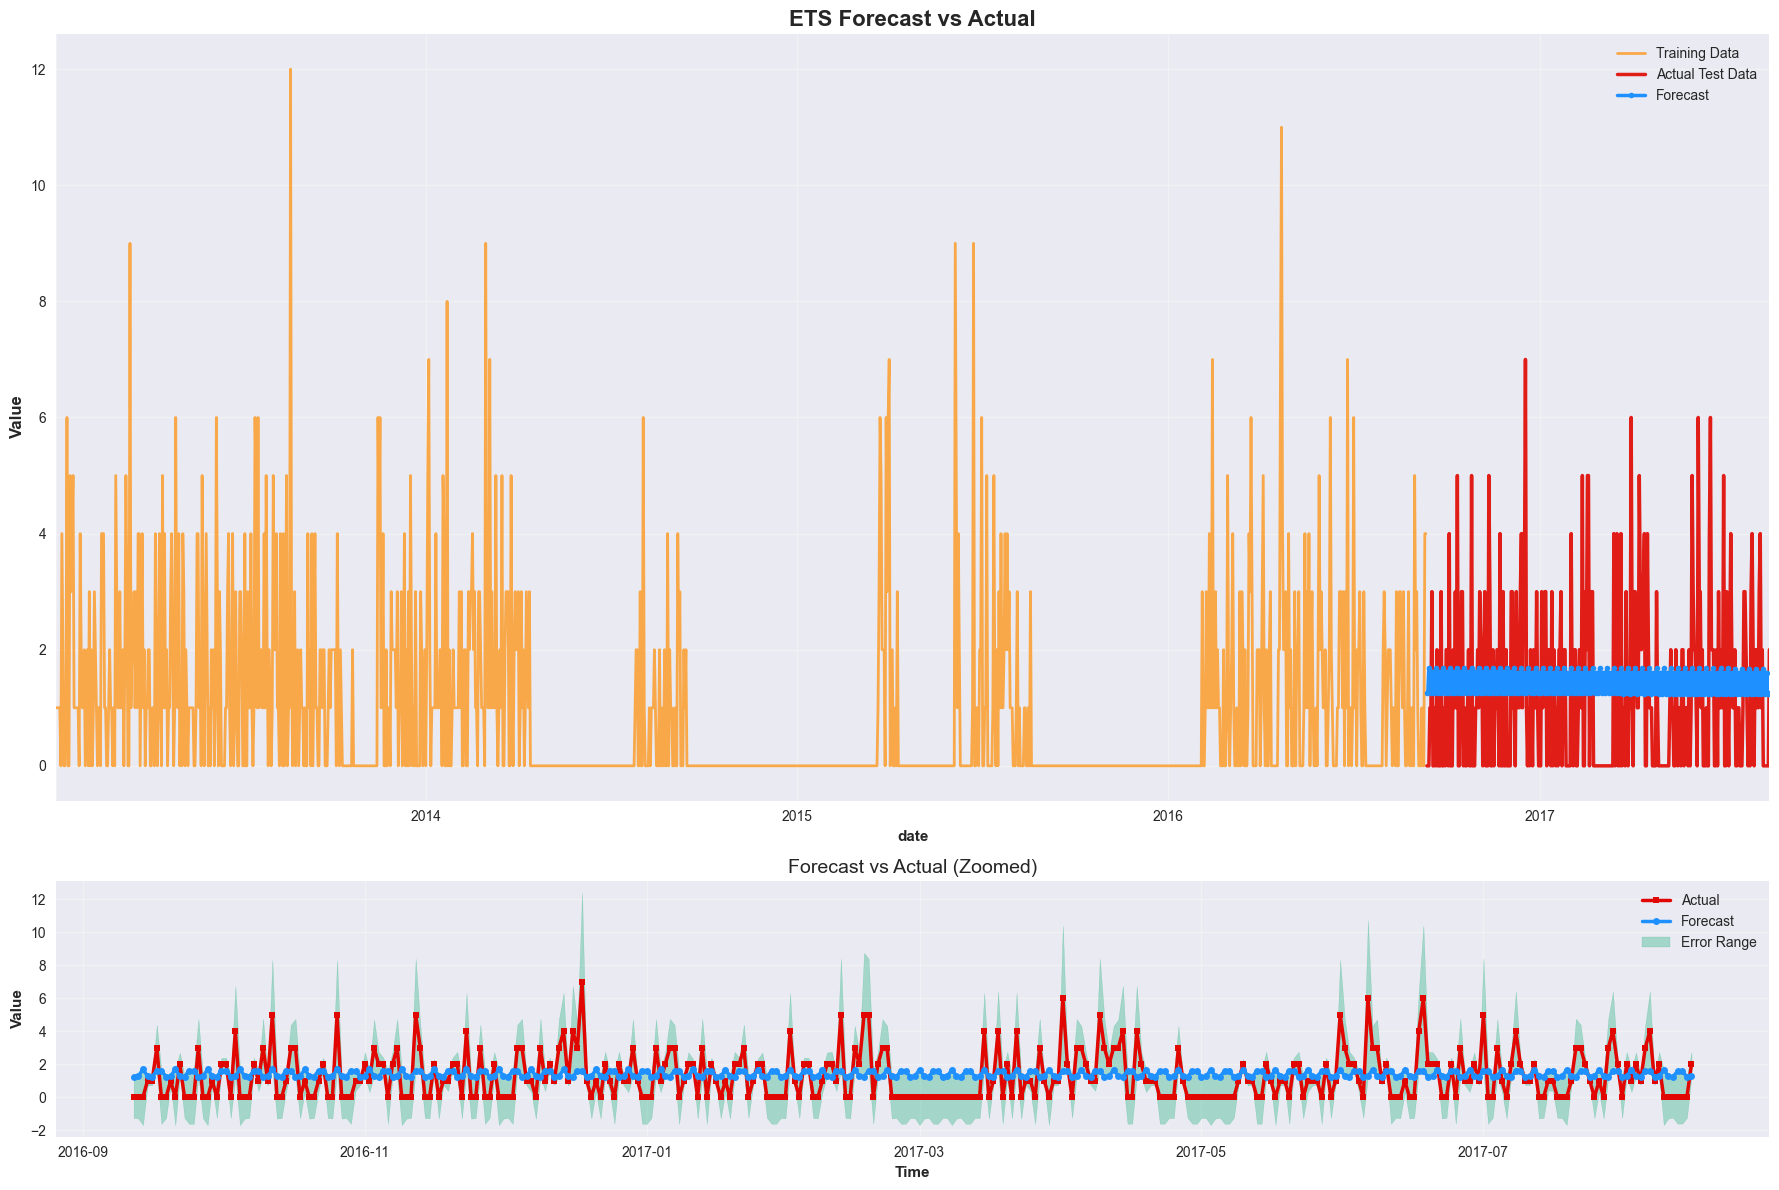

2026-01-05 17:23:43,054 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:43,055 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:43,055 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:43,056 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0262)
2026-01-05 17:23:43,056 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:23:43,101 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:43,101 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:43,101 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:43,104 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 24, Item 105577: RMSE=1.44, MAPE=5910855832.90%


--------------------------------------------------------------------------------
▶ Series 2: Store 24, Item 105574
--------------

2026-01-05 17:23:46,605 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

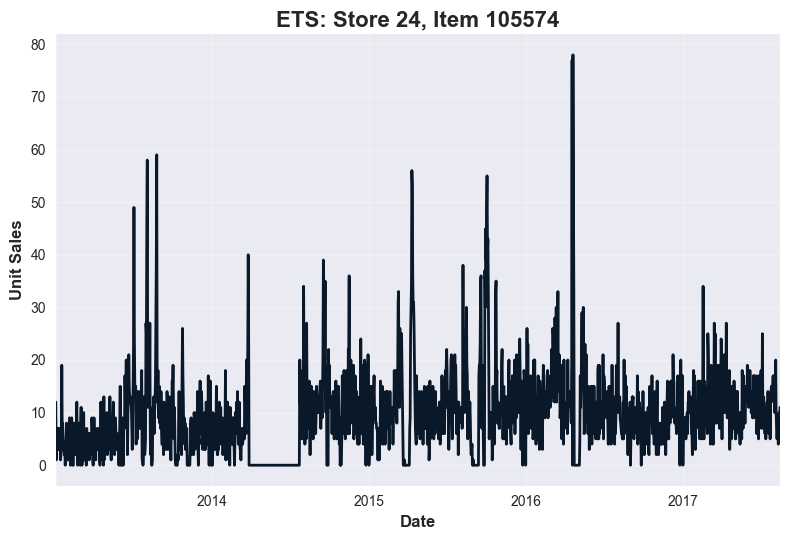

[TimeSeriesViz] Generating enhanced forecast overlay...


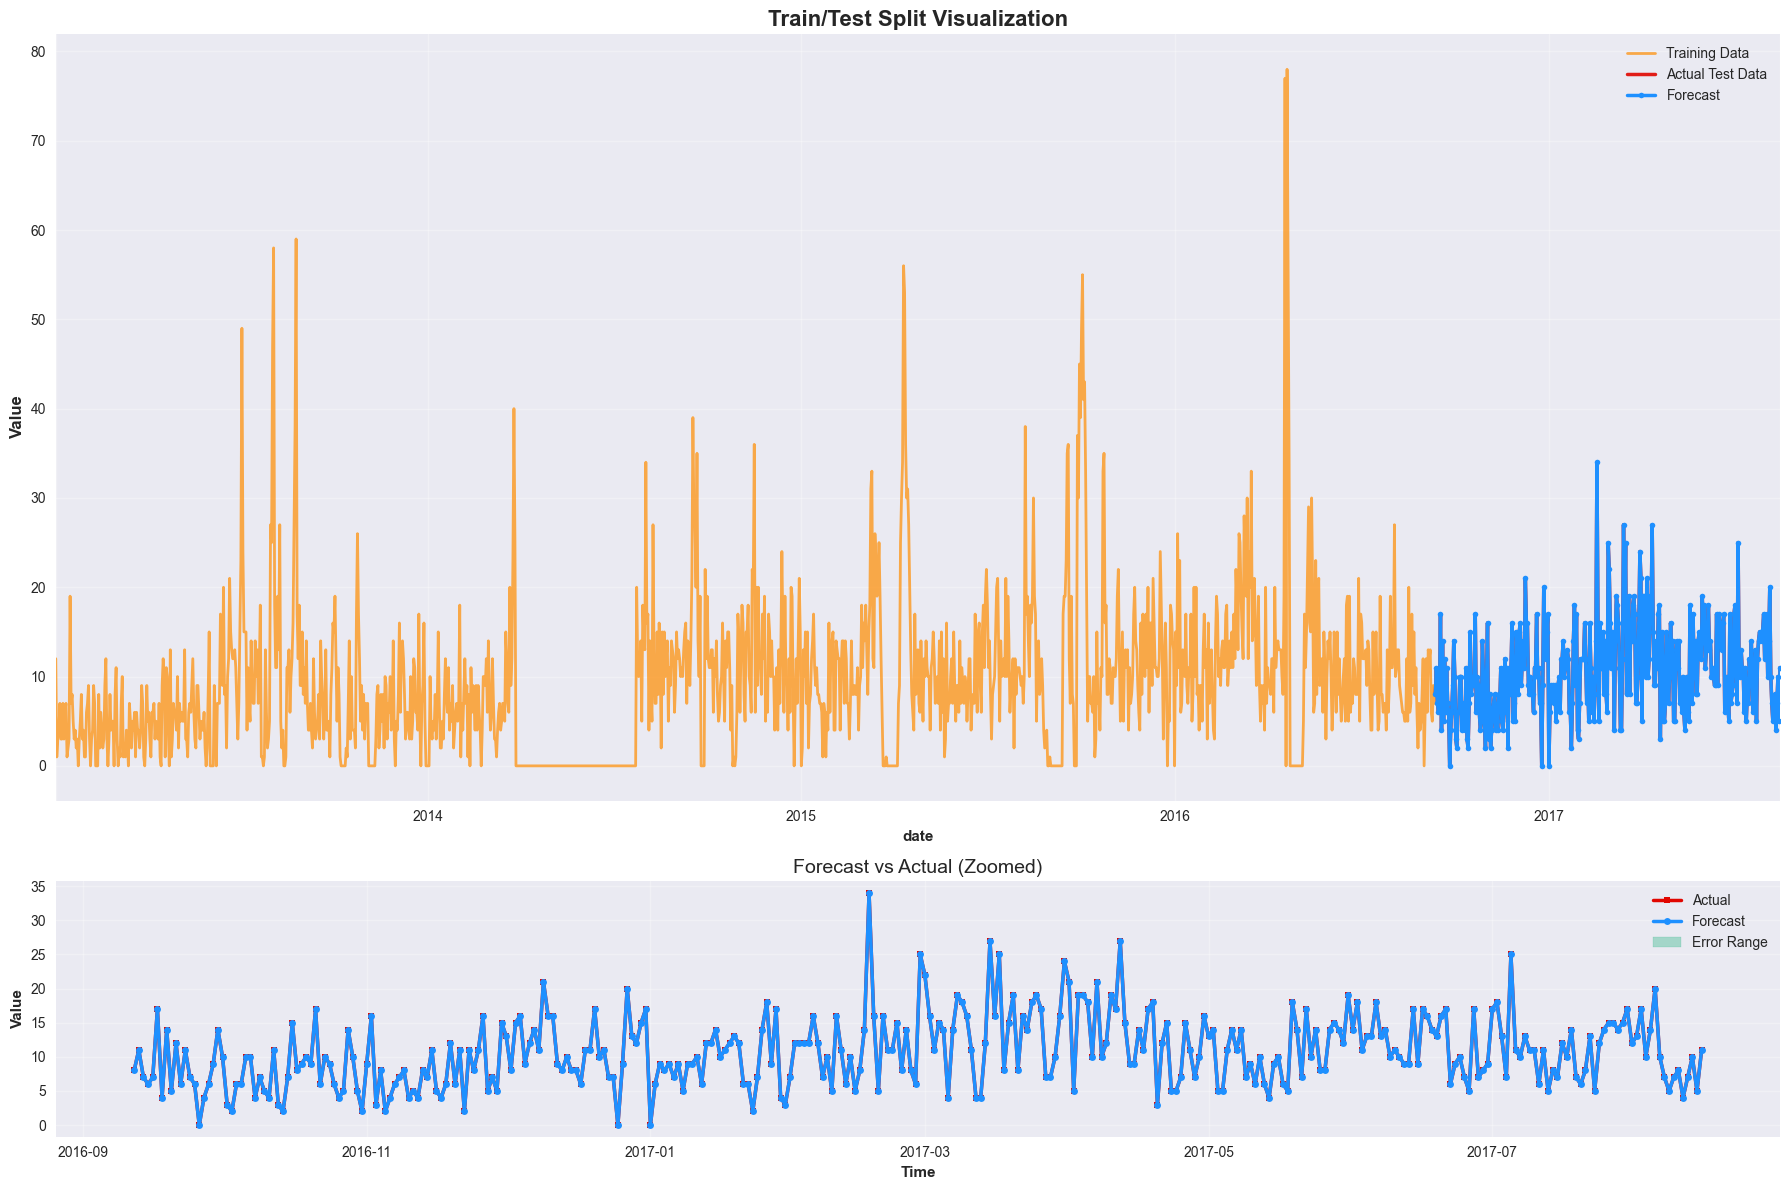

2026-01-05 17:23:47,342 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:47,342 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:23:47,342 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:47,342 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:47,485 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:47,486 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:47,486 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:23:47,494 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


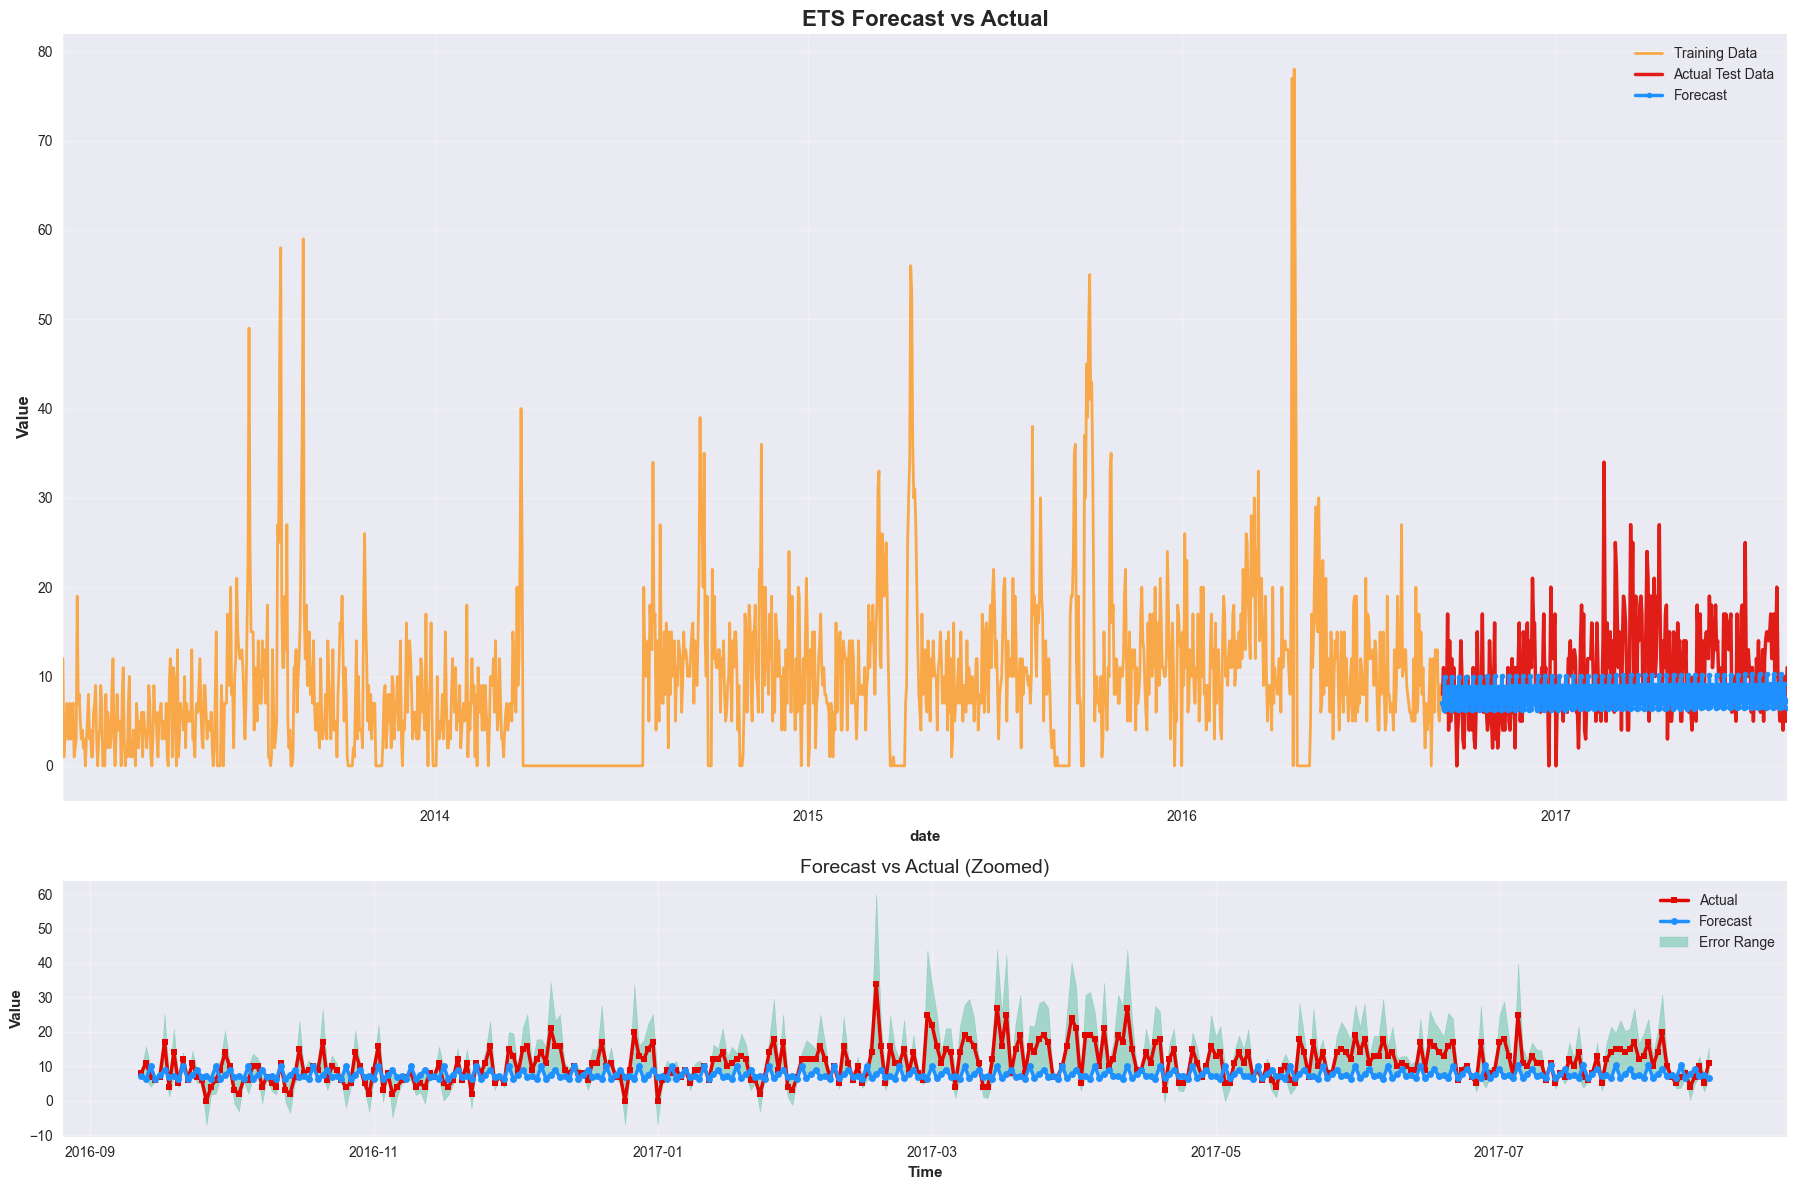

2026-01-05 17:23:48,050 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:48,050 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:48,050 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:48,052 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0000)
2026-01-05 17:23:48,052 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:23:48,076 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:48,076 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:48,076 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:48,078 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 24, Item 105574: RMSE=5.86, MAPE=620857237.47%


--------------------------------------------------------------------------------
▶ Series 3: Store 26, Item 105577
---------------

2026-01-05 17:23:51,498 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

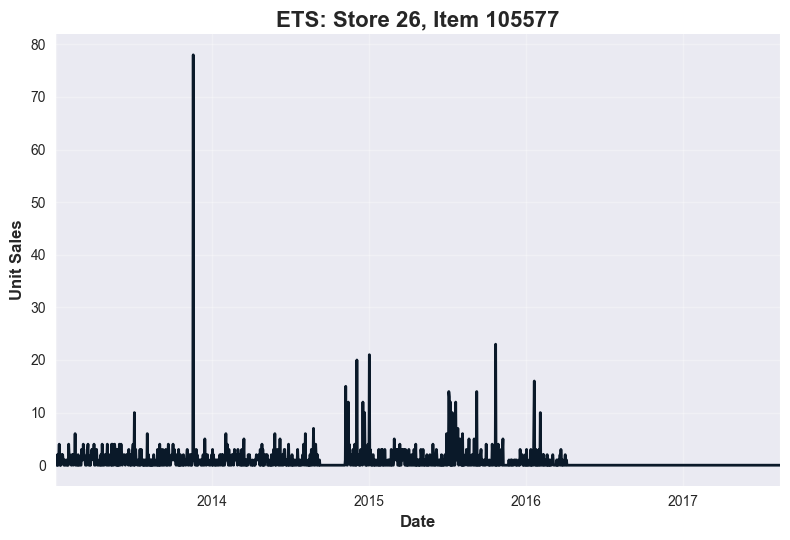

[TimeSeriesViz] Generating enhanced forecast overlay...


2026-01-05 17:23:52,078 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:52,079 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:23:52,079 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:52,079 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:52,223 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:52,224 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:52,224 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:23:52,232 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


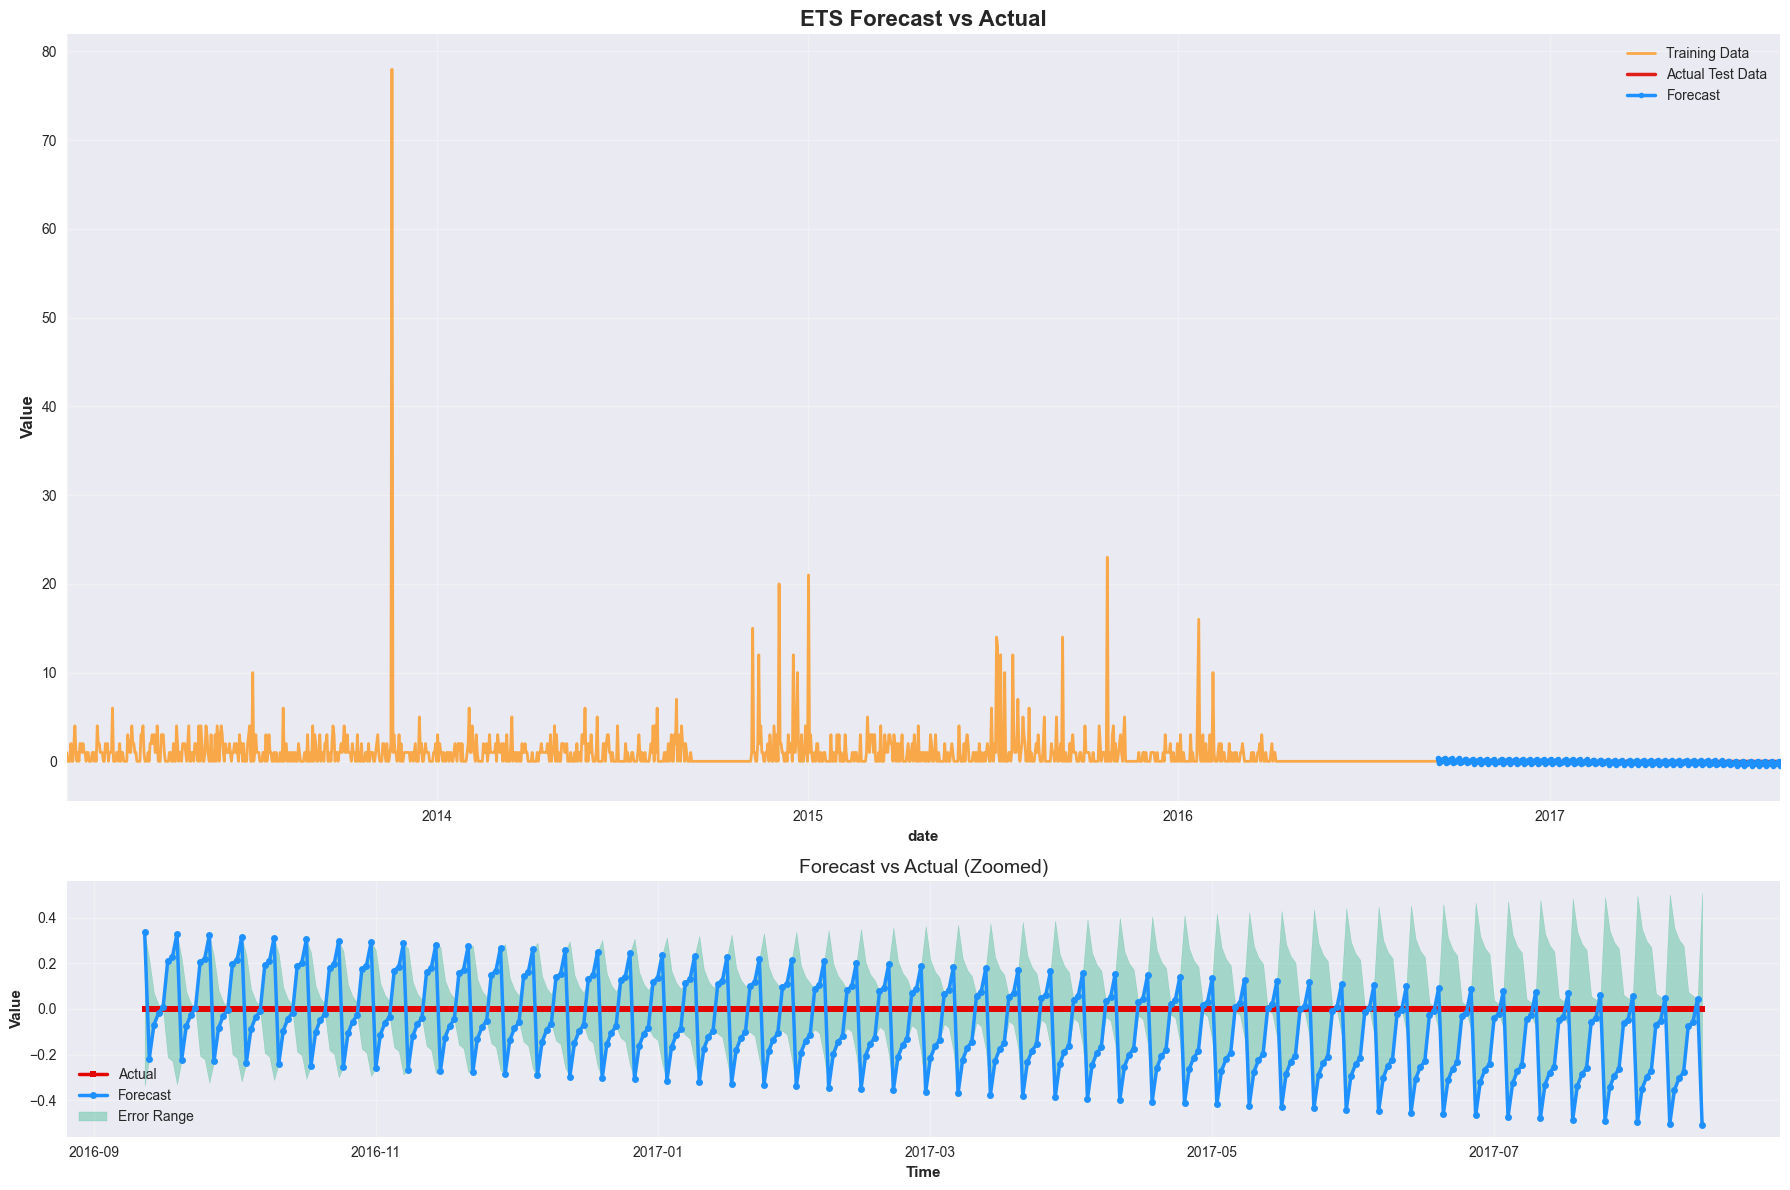

2026-01-05 17:23:52,737 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:52,737 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:52,737 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:52,739 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0000)
2026-01-05 17:23:52,739 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:23:52,759 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:52,759 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:52,759 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:52,761 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 26, Item 105577: RMSE=0.21, MAPE=1790762845.64%


--------------------------------------------------------------------------------
▶ Series 4: Store 26, Item 105575
--------------

2026-01-05 17:23:56,433 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

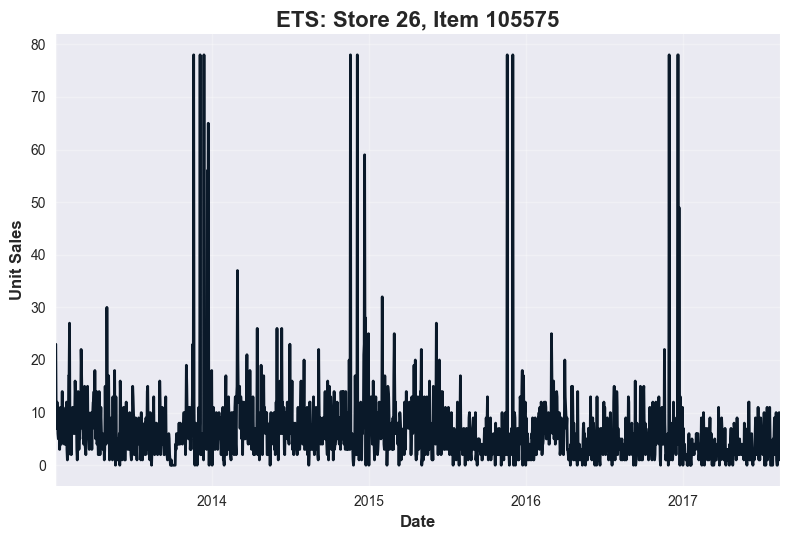

[TimeSeriesViz] Generating enhanced forecast overlay...


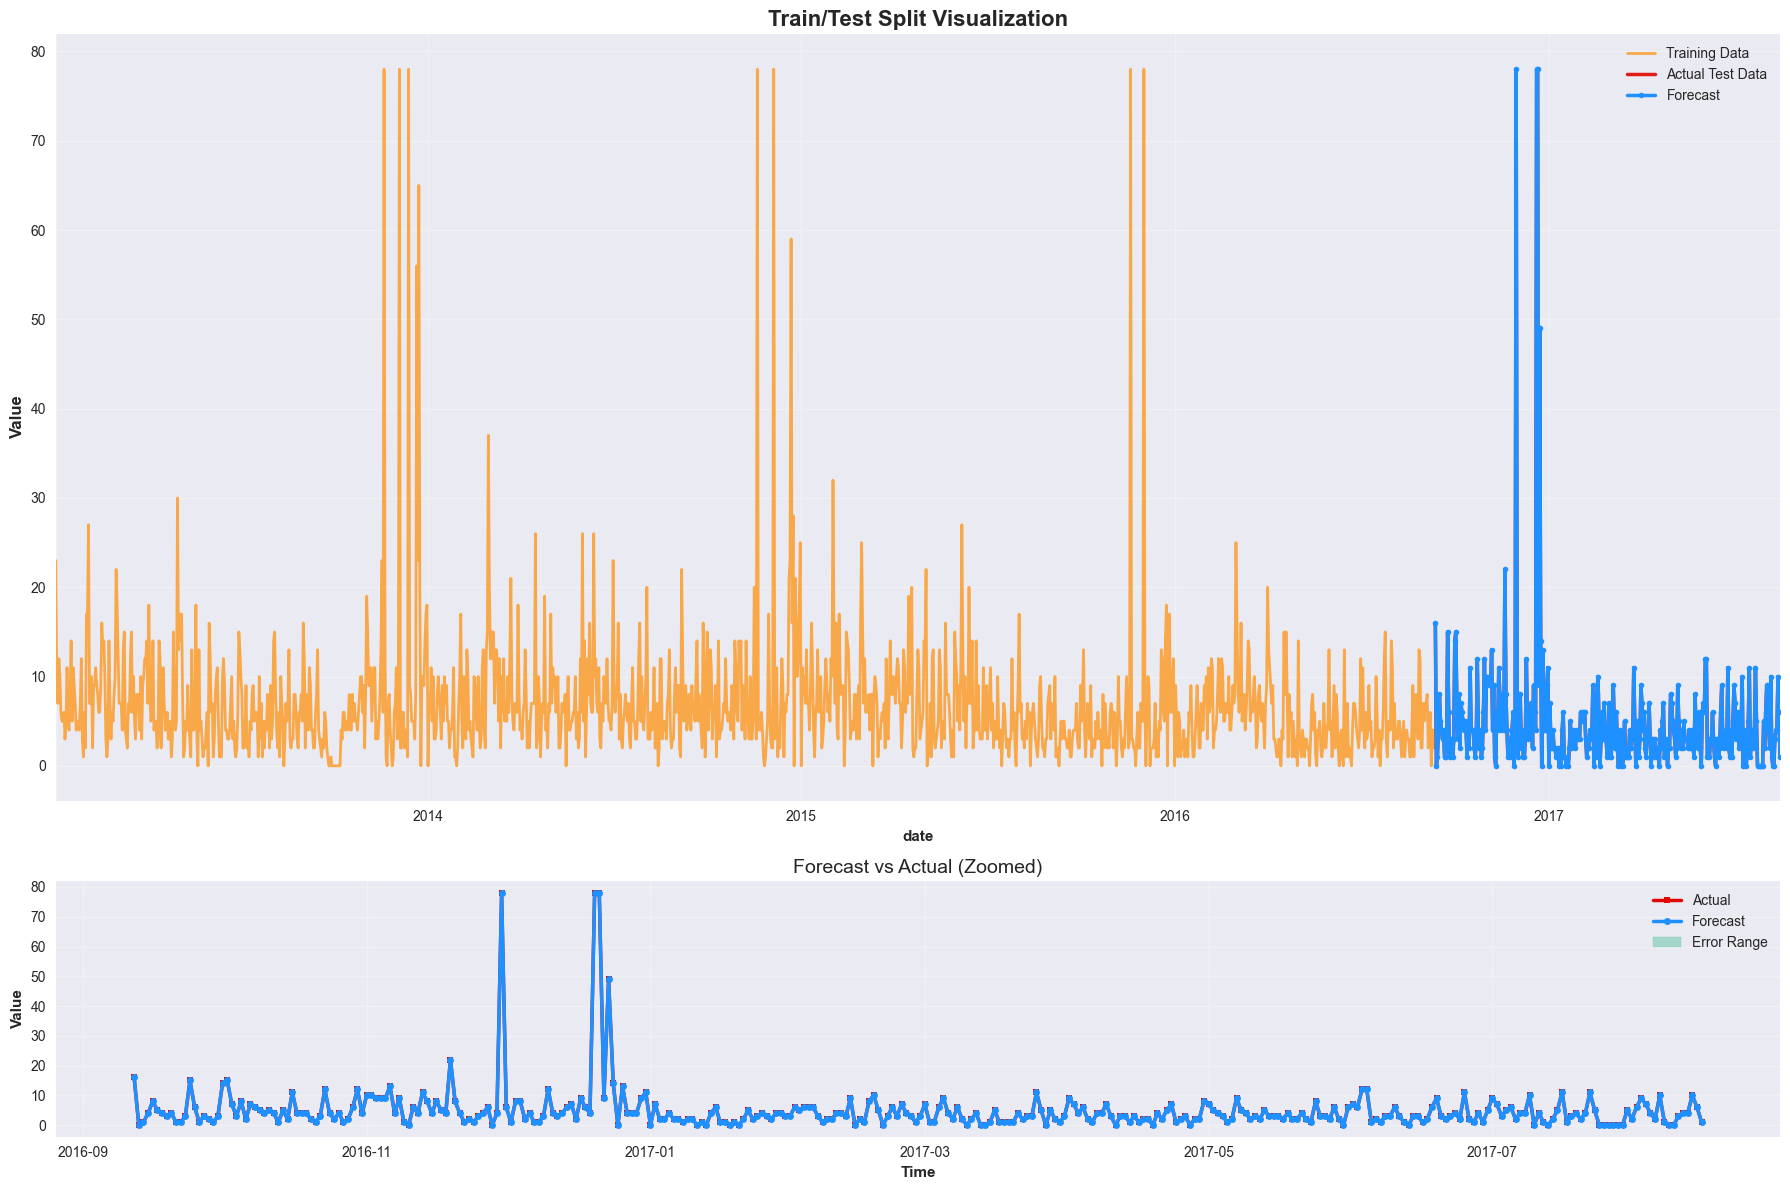

2026-01-05 17:23:57,180 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:23:57,180 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:23:57,180 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:23:57,180 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:23:57,320 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:23:57,321 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:23:57,322 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:23:57,329 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


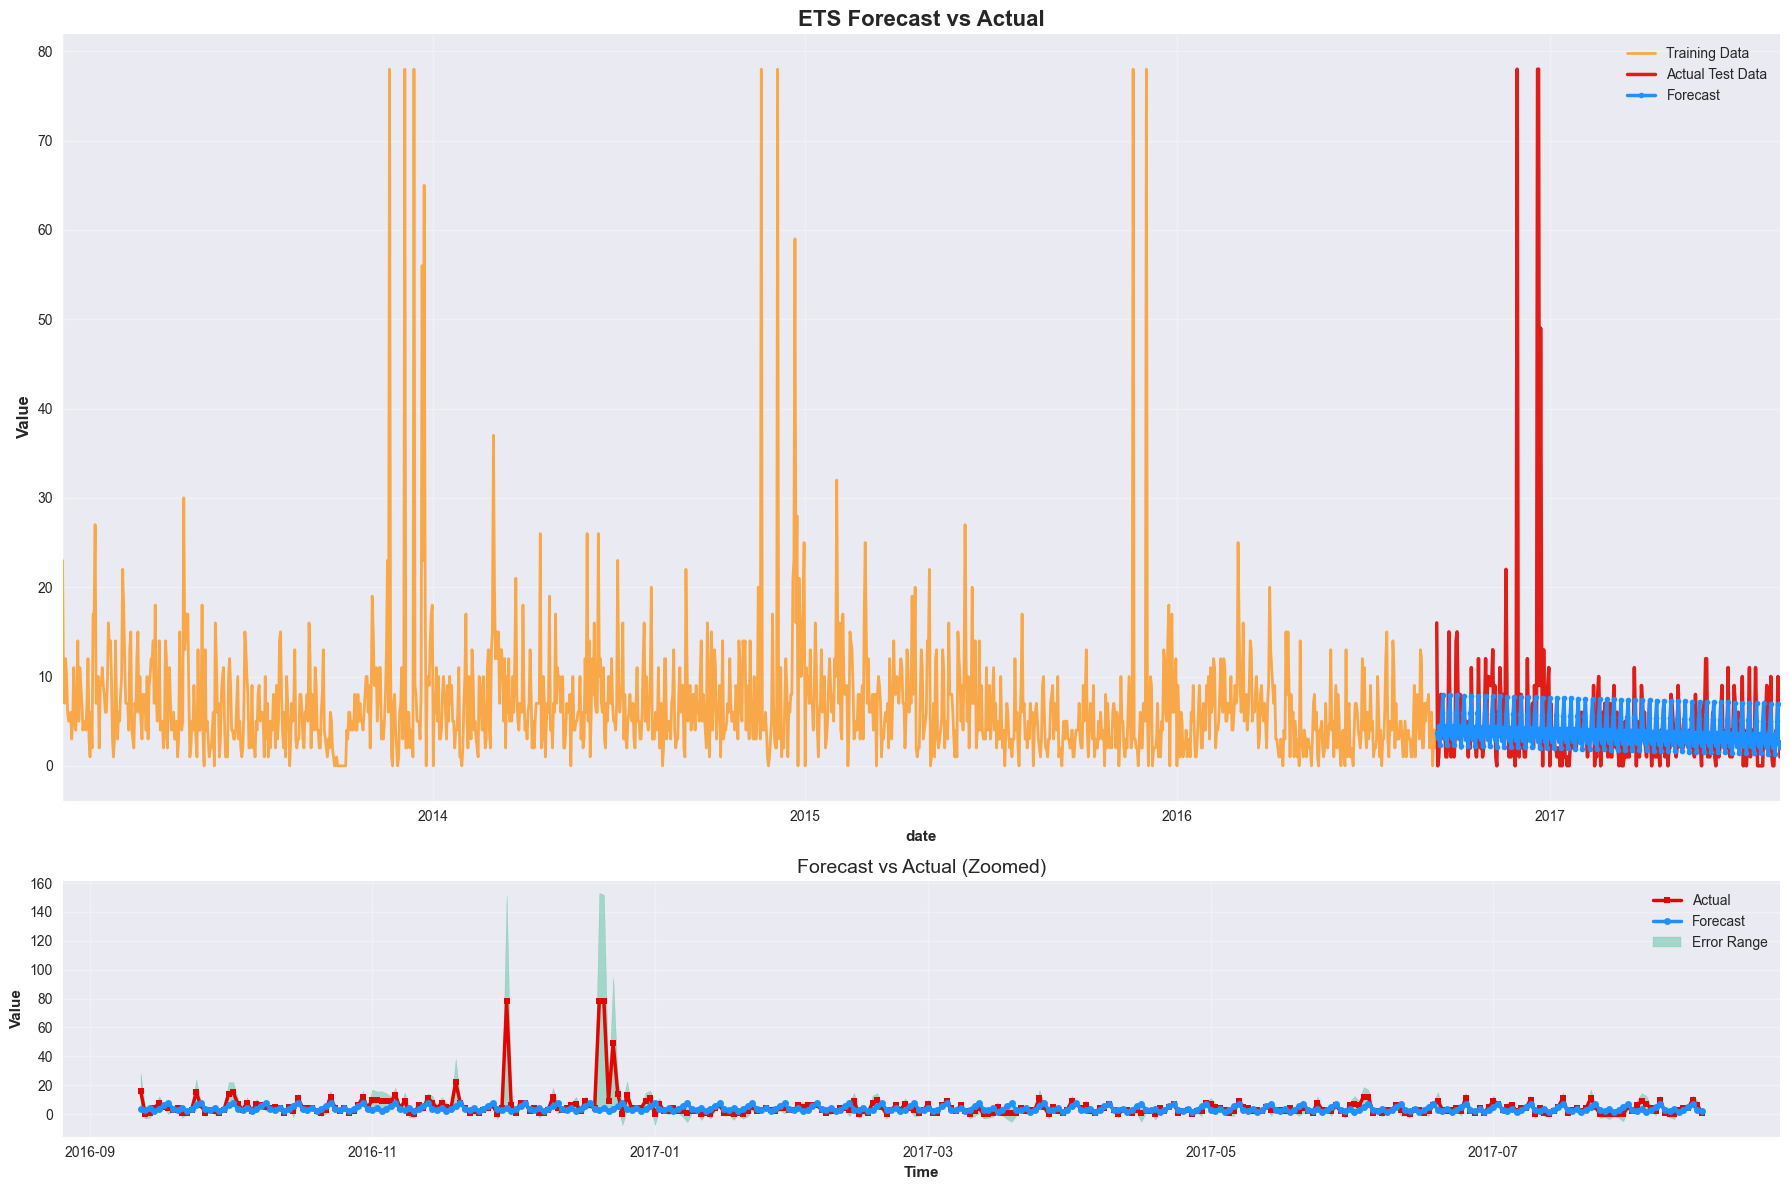

2026-01-05 17:23:57,908 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:23:57,909 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:23:57,909 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:23:57,911 - src.core.week_2.models.ets.ets_evaluator - WARNING - Ljung-Box test: Significant autocorrelation detected (p=0.0000)
2026-01-05 17:23:57,911 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:23:57,938 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:23:57,938 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:23:57,938 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:23:57,940 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 26, Item 105575: RMSE=8.04, MAPE=2843273040.17%


--------------------------------------------------------------------------------
▶ Series 5: Store 27, Item 105577
--------------

2026-01-05 17:24:01,487 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

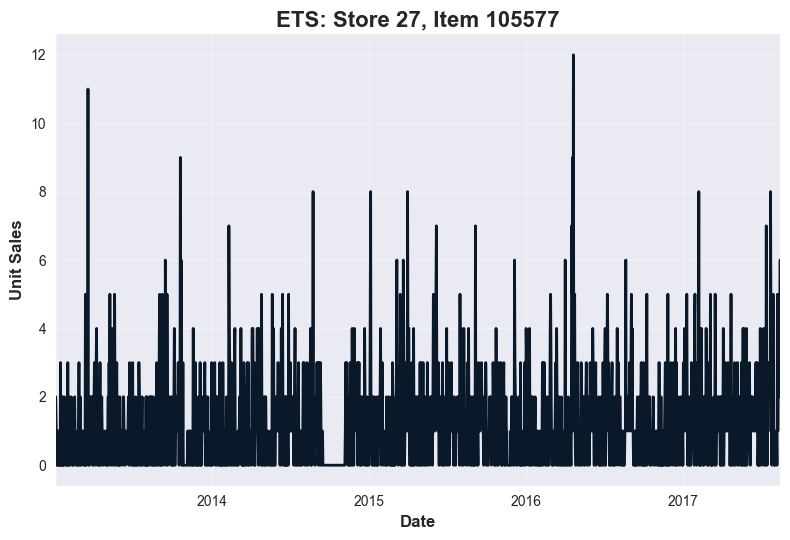

[TimeSeriesViz] Generating enhanced forecast overlay...


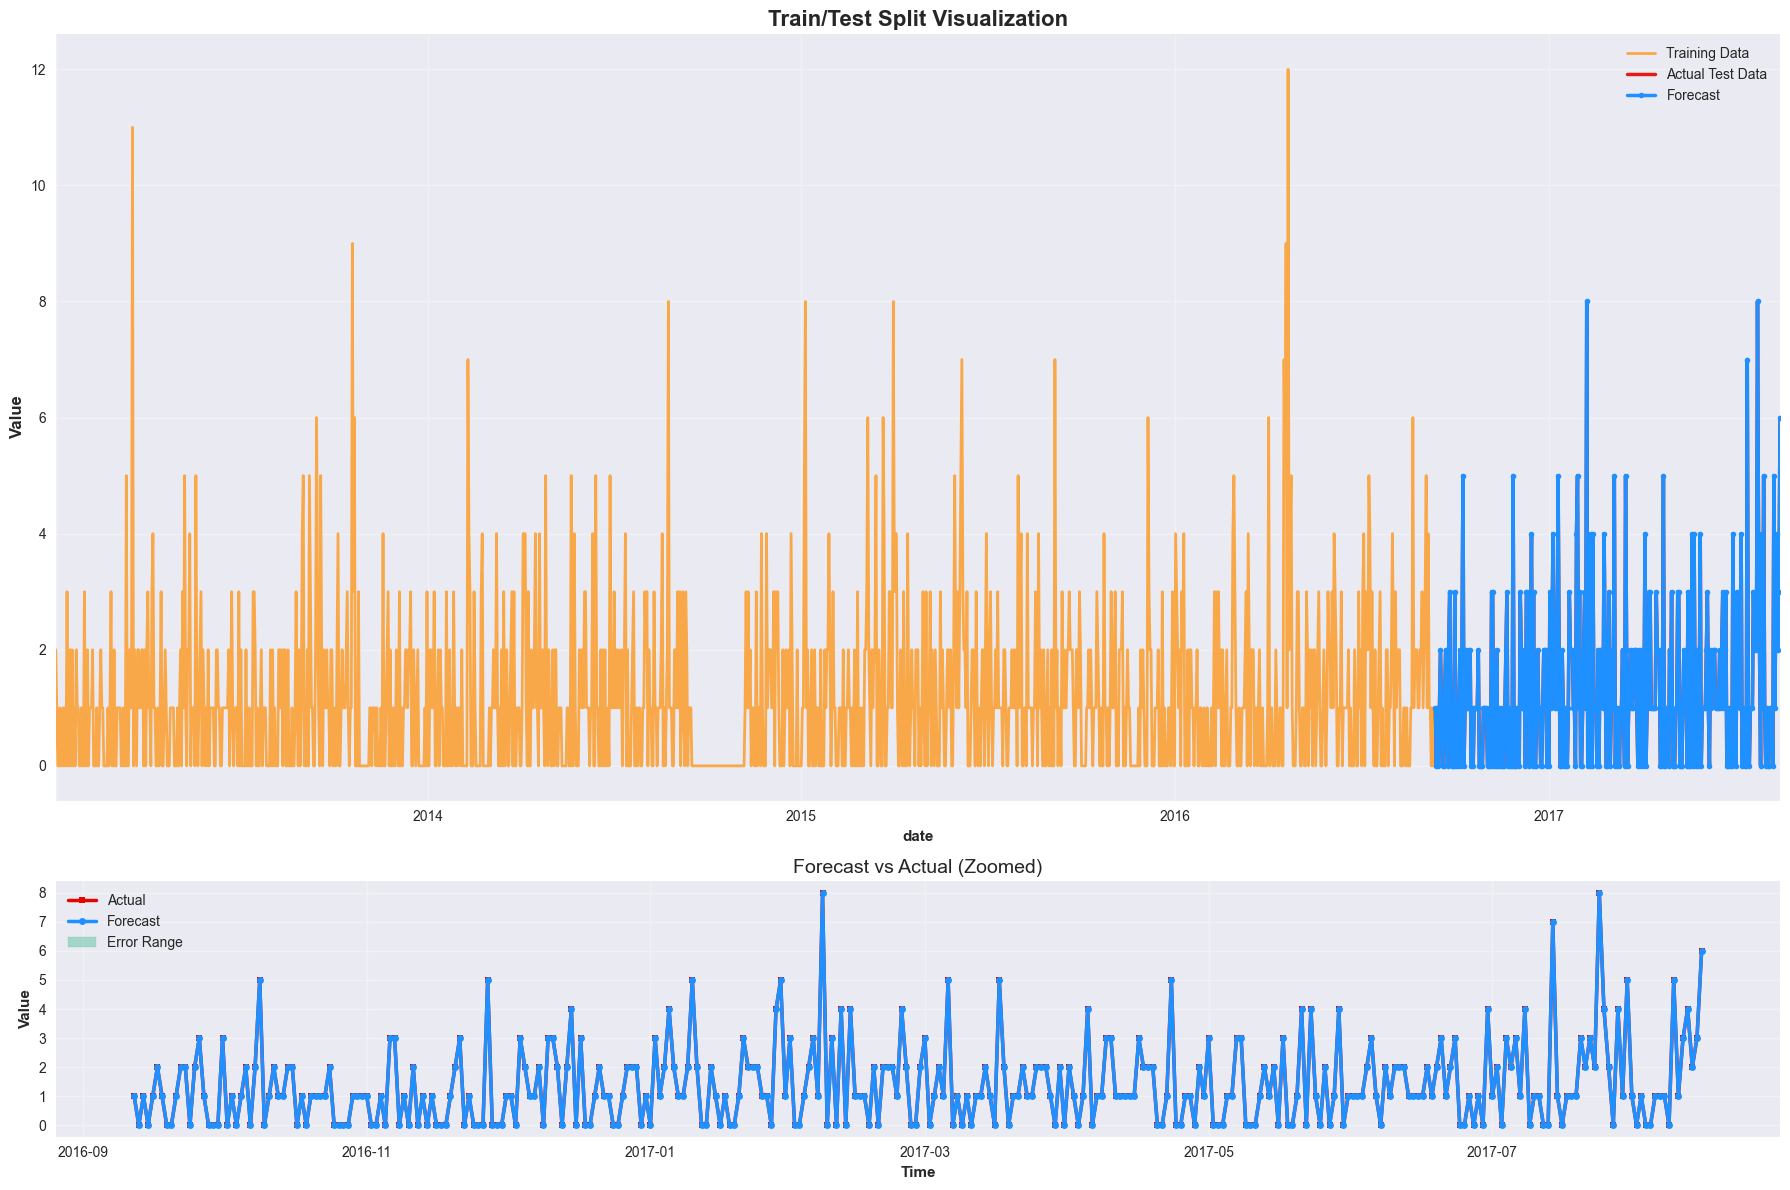

2026-01-05 17:24:02,275 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:24:02,275 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:02,275 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:02,275 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:24:02,429 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:02,430 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:02,430 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:24:02,438 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


2026-01-05 17:24:03,053 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:24:03,053 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:24:03,054 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:24:03,055 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:24:03,076 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:24:03,076 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:24:03,076 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully
2026-01-05 17:24:03,078 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:24:

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 27, Item 105577: RMSE=1.40, MAPE=4374228454.28%


--------------------------------------------------------------------------------
▶ Series 6: Store 51, Item 105577
--------------

2026-01-05 17:24:06,568 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

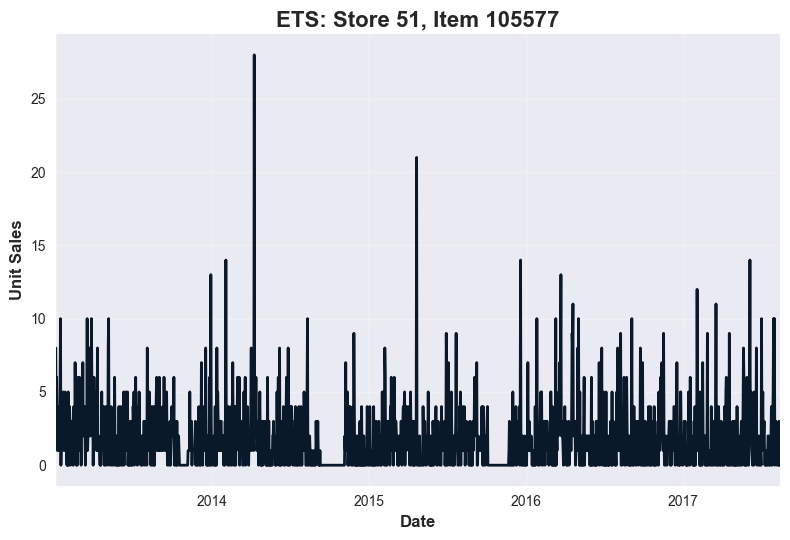

[TimeSeriesViz] Generating enhanced forecast overlay...


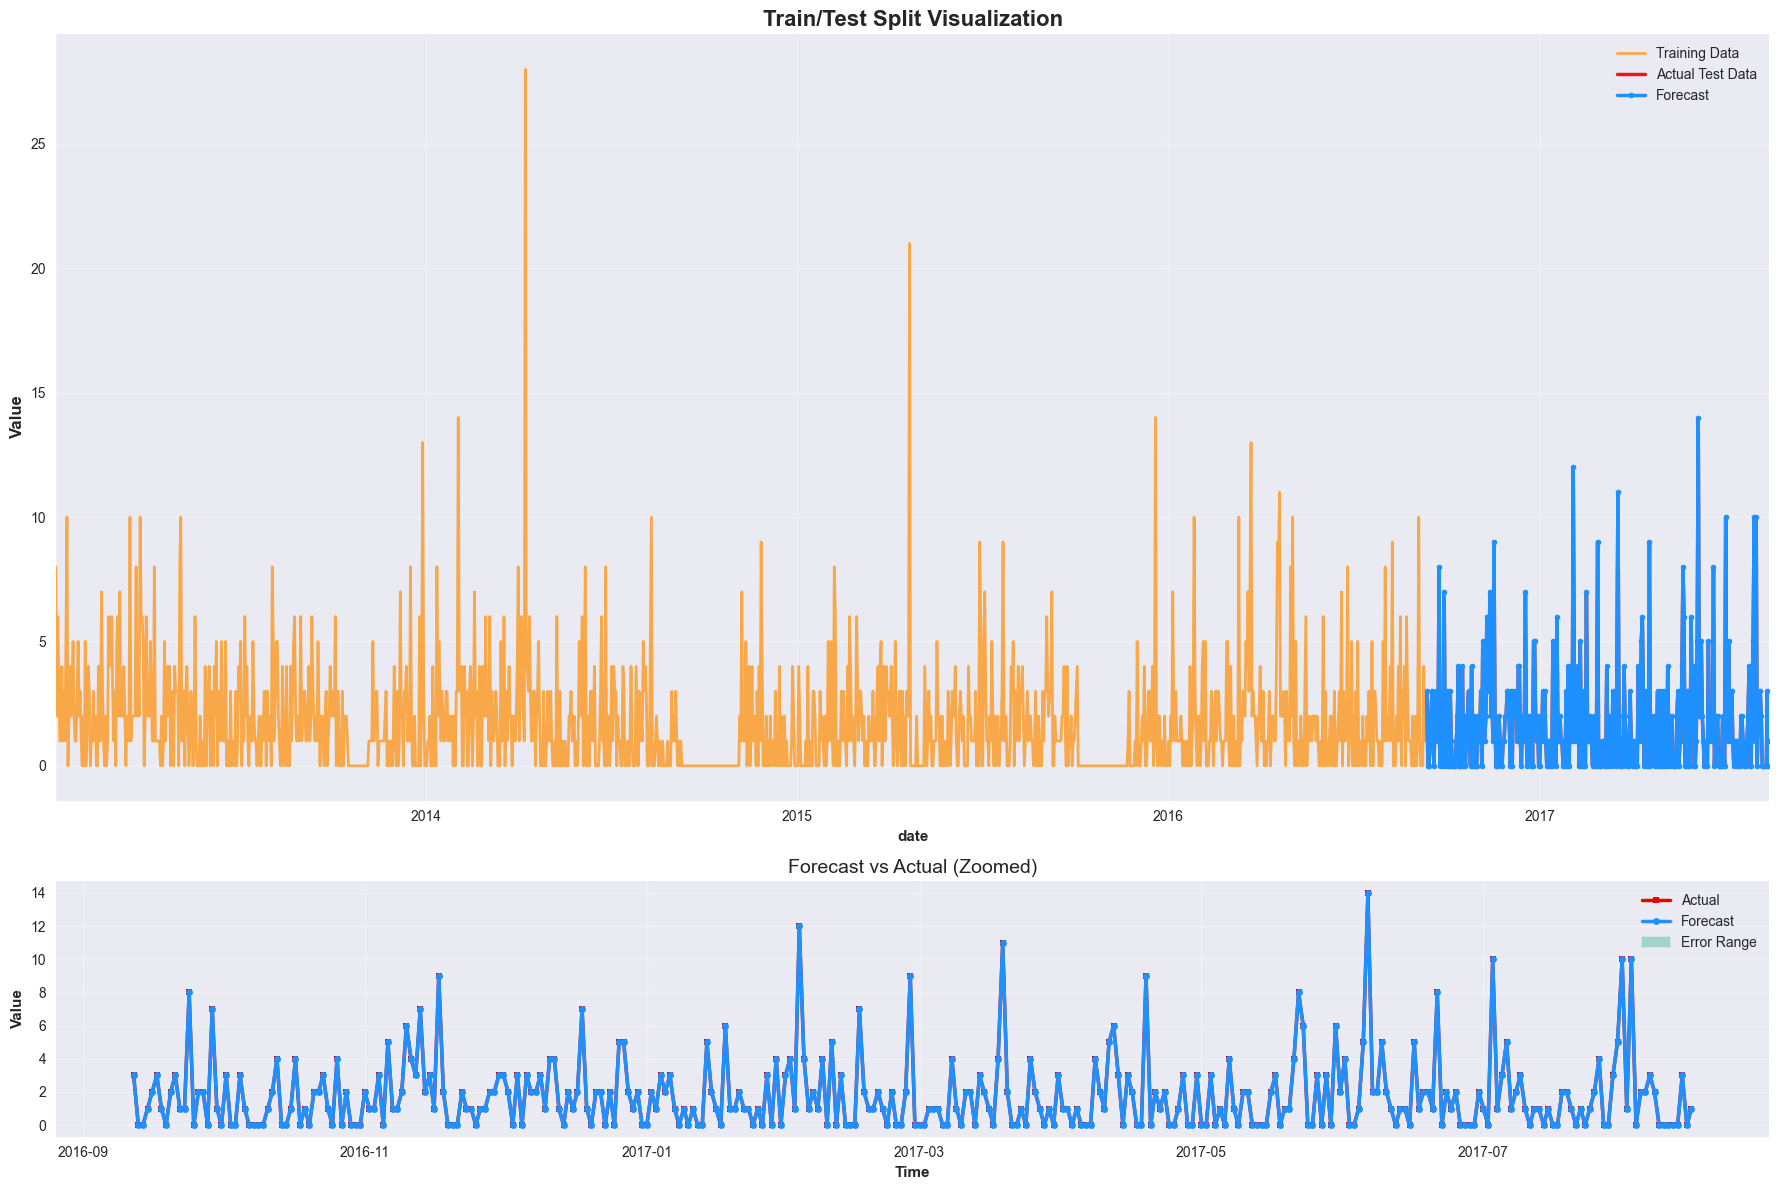

2026-01-05 17:24:07,324 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:24:07,325 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:07,325 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:07,325 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:24:07,474 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:07,476 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:07,476 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting forecast generation
2026-01-05 17:24:07,483 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Forecast data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/w

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
[TimeSeriesViz] Generating enhanced forecast overlay...


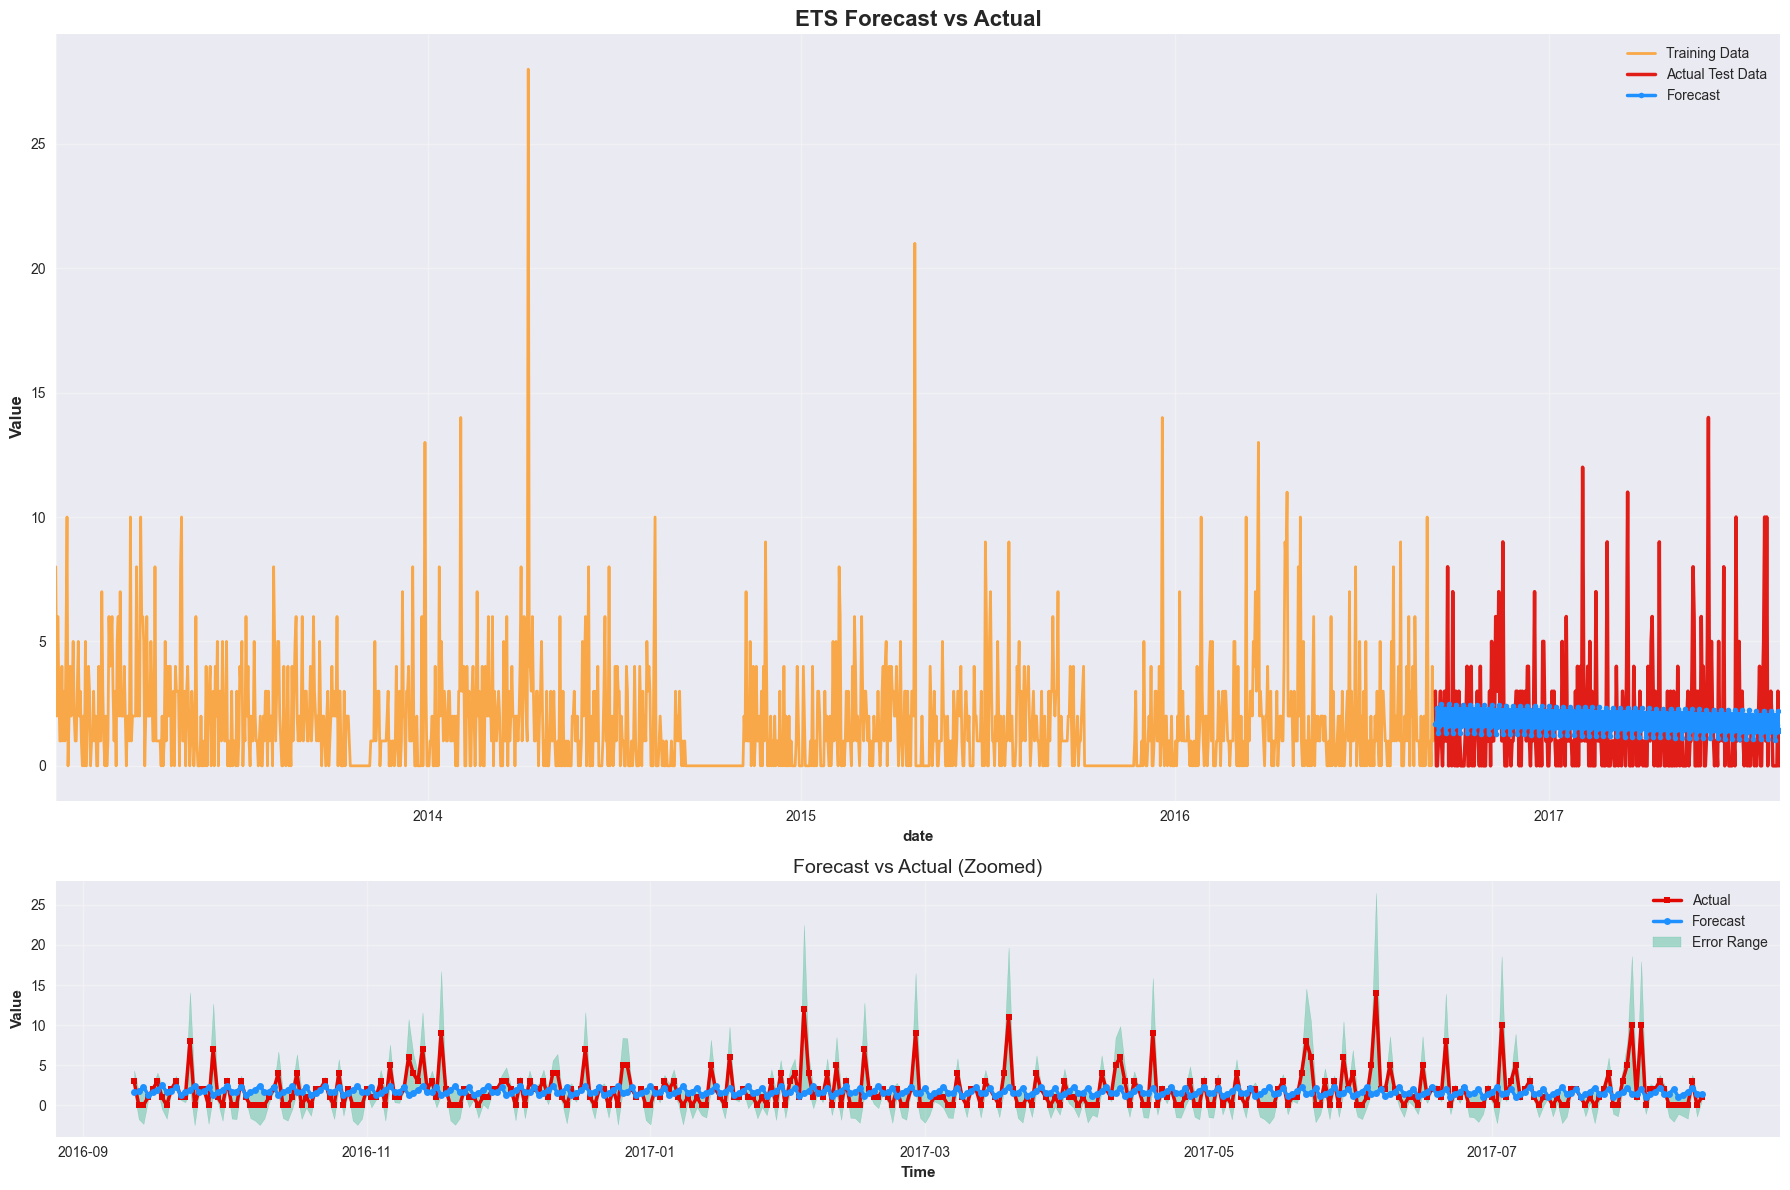

2026-01-05 17:24:08,072 - src.core.week_2.models.ets.ets_pipeline - INFO - Forecast generation completed
2026-01-05 17:24:08,072 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model evaluation
2026-01-05 17:24:08,072 - src.core.week_2.models.ets.ets_evaluator - INFO - Starting ETS evaluation on 338 observations
2026-01-05 17:24:08,074 - src.core.week_2.models.ets.ets_evaluator - INFO - ETS evaluation completed successfully
2026-01-05 17:24:08,095 - src.core.week_2.models.ets.ets_pipeline - INFO - MLflow logging completed
2026-01-05 17:24:08,095 - src.core.week_2.models.ets.ets_pipeline - INFO - Model evaluation completed
2026-01-05 17:24:08,095 - src.core.week_2.models.ets.ets_pipeline - INFO - Full pipeline execution completed successfully


💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/03_forecast_overlay.png
✅ ETS evaluation completed
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/evaluation_metrics.json
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/full_evaluation_metrics.json
📊 Metrics logged to MLflow under experiment 'ETS'.
💾 MLflow metrics also saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/mlflow/mlflow_evaluation_metrics.json
✅ Store 51, Item 105577: RMSE=2.23, MAPE=5625868094.75%


In [16]:
# ================================================================
# 📘 EXPERIMENT 3 — MULTI-SERIES FORECASTING (RUN PIPELINES)
# This cell runs the full ETS pipeline for each store–item pair,
# handles fallback/skip/shift logic, and stores all results.
# ================================================================

print_header("EXPERIMENT 3: MULTI-SERIES FORECASTING")

results_multi = []

for idx, (stores, items) in enumerate(ETSNotebookConfig.MULTI_SERIES, start=1):
    print("\n" + "="*90)
    print_section(f"Series {idx}: Store {stores[0]}, Item {items[0]}")
    print("="*90)

    start_time = time.time()

    try:
        # Initialize pipeline
        pipeline = ETSPipeline(
            store_ids=stores,
            item_ids=items,
            week=ETSNotebookConfig.WEEK,
            verbose=False,
            use_mlflow=ETSNotebookConfig.USE_MLFLOW,
        )

        # Run full pipeline (with default config)
        result = pipeline.run_full_pipeline(
            df=df,
            split_ratio=ETSNotebookConfig.SPLIT_RATIO,
            custom_params=None,   # use default ETS config
        )

        # Handle SKIPPED series
        if isinstance(result, dict) and result.get("status") == "skipped":
            print(f"⚠️ Series {idx} skipped due to multiplicative ETS constraints.")
            elapsed_time = time.time() - start_time

            results_multi.append({
                "store_id": stores[0],
                "item_id": items[0],
                "status": "skipped",
                "time_seconds": elapsed_time,
            })
            continue

        # Successful series
        metrics = result
        elapsed_time = time.time() - start_time

        results_multi.append({
            "store_id": stores[0],
            "item_id": items[0],
            "train_size": len(pipeline.train),
            "test_size": len(pipeline.test),
            "mae": metrics["mae"],
            "rmse": metrics["rmse"],
            "mape": metrics["mape"],
            "smape": metrics["smape"],
            "mase": metrics["mase"],
            "r2": metrics["r2"],
            "status": "success",
            "time_seconds": elapsed_time,
        })

        print(f"✅ Store {stores[0]}, Item {items[0]}: "
              f"RMSE={metrics['rmse']:.2f}, MAPE={metrics['mape']:.2f}%")

    except Exception as e:
        print(f"❌ Series {idx} failed: {e}")
        logger.error(f"Series {idx} failed: {e}")


### *6.2 Multi‑Series Results Summary + Comparison Plots*

This cell prints all results in a table and generates comparison plots for RMSE and MAPE across all series.


                   EXPERIMENT 3 SUMMARY — ALL SERIES RESULTS                    



store_id  item_id  train_size  test_size       mae      rmse          mape       smape          mase        r2  \
0        24   105577        1349        338  1.207293  1.437974  5.910856e+09  113.670645  8.961626e-01  0.019079   
1        24   105574        1349        338  4.470059  5.861219  6.208572e+08   45.663471  9.576667e-01 -0.309404   
2        26   105577        1349        338  0.179076  0.214432  1.790763e+09  199.999964  1.790763e+07  0.000000   
3        26   105575        1349        338  3.098719  8.035202  2.843273e+09   68.164581  7.605742e-01  0.009834   
4        27   105577        1349        338  1.081665  1.404120  4.374228e+09   92.221856  7.454423e-01  0.020022   
5        51   105577        1349        338  1.541363  2.225329  5.625868e+09  103.279959  7.154813e-01  0.003392   

    status  time_seconds  
0  success      5.001094  
1  success      4.974207  
2  success      4.682808  
3  success      5.179160  
4  success      5.137722  
5  success      5.019416

2026-01-05 17:24:08,171 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-05 17:24:08,172 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


💾 Results saved to experiment3_multi_series_results.csv

                  EXPERIMENT 3 — PERFORMANCE COMPARISON PLOTS                   



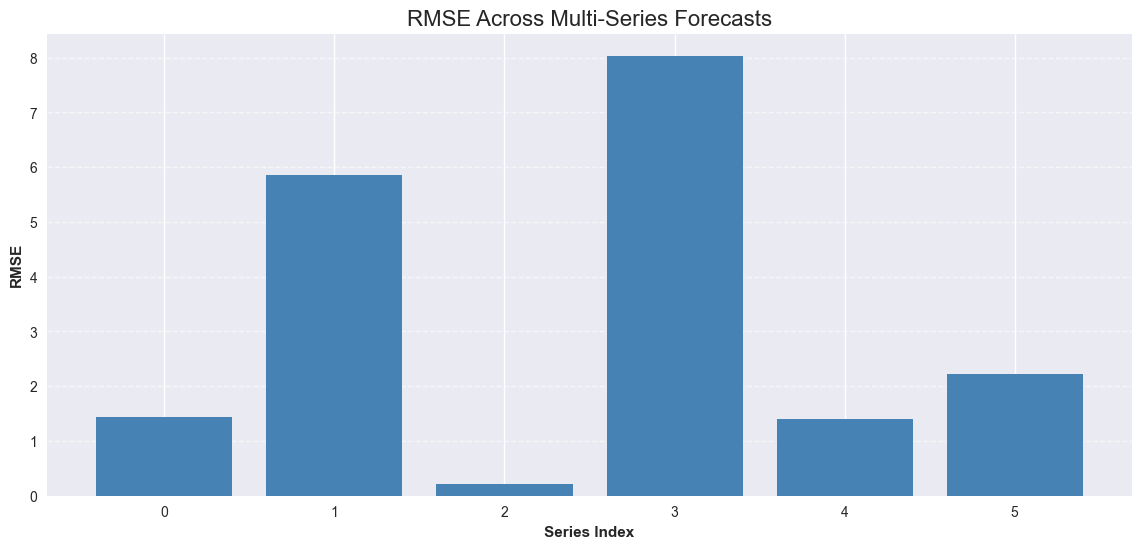

2026-01-05 17:24:08,209 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-05 17:24:08,210 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


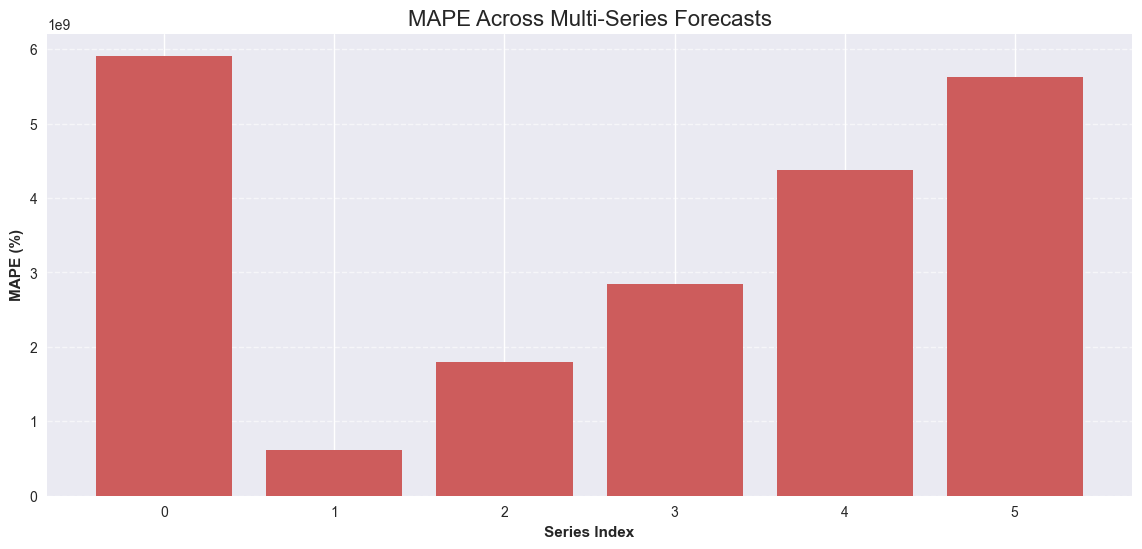

In [17]:
# ================================================================
# 📘 EXPERIMENT 3 — RESULTS SUMMARY & COMPARISON PLOTS
# This cell displays all stored results and generates comparison
# plots (RMSE + MAPE) for successful multi-series forecasts.
# ================================================================

print_header("EXPERIMENT 3 SUMMARY — ALL SERIES RESULTS")

df_multi = pd.DataFrame(results_multi)
display(df_multi)

# Save results
df_multi.to_csv("experiment3_multi_series_results.csv", index=False)
print("💾 Results saved to experiment3_multi_series_results.csv")

# ---------------------------------------------------------------
# COMPARISON PLOTS
# ---------------------------------------------------------------
print_header("EXPERIMENT 3 — PERFORMANCE COMPARISON PLOTS")

df_success = df_multi[df_multi["status"] == "success"]

if len(df_success) > 0:
    # RMSE plot
    plt.figure(figsize=(14, 6))
    plt.title("RMSE Across Multi-Series Forecasts", fontsize=16)
    plt.bar(
        df_success.index.astype(str),
        df_success["rmse"],
        color="steelblue"
    )
    plt.xlabel("Series Index")
    plt.ylabel("RMSE")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

    # MAPE plot
    plt.figure(figsize=(14, 6))
    plt.title("MAPE Across Multi-Series Forecasts", fontsize=16)
    plt.bar(
        df_success.index.astype(str),
        df_success["mape"],
        color="indianred"
    )
    plt.xlabel("Series Index")
    plt.ylabel("MAPE (%)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

else:
    print("⚠️ No successful series to plot.")




### *6.3 ETS Multi-Series Forecasting*

#### **6.3.1 Objective**
To assess the robustness and adaptability of ETS models across six distinct store–item combinations, each representing unique demand patterns, volatility profiles, and sales sparsity. The goal: identify where ETS excels, where it falters, and what signals future modeling directions.

<br>

#### *6.3.2 Series Performance Breakdown*

##### `6.3.2.1 Series 0 — Store 24, Item 105577`
- **RMSE**: 1.44 | **MAE**: 1.21 | **MAPE**: 5.91B% | **SMAPE**: 113.67% | **R²**: 0.019  
- **Insight**: A well-behaved forecast with low error and modest explanatory power. However, the extreme MAPE reflects zero-inflated sales, distorting percentage-based metrics.  
- **Rank**: 3rd lowest RMSE, 2nd best R²

##### `6.3.2.2 Series 1 — Store 24, Item 105574`
- **RMSE**: 5.86 | **MAE**: 4.47 | **MAPE**: 620.86M% | **SMAPE**: 45.66% | **R²**: -0.309  
- **Insight**: The model struggles with sharp demand spikes, leading to the 2nd highest RMSE and negative R². SMAPE is relatively low, suggesting better proportional accuracy than raw error implies.  
- **Rank**: Worst R², 2nd highest RMSE

##### `6.3.2.3 Series 2 — Store 26, Item 105577`
- **RMSE**: 0.21 | **MAE**: 0.18 | **MAPE**: 1.79B% | **SMAPE**: 200.00% | **R²**: 0.000  
- **Insight**: The lowest RMSE and MAE across all series—an outstanding fit. Yet, SMAPE and MAPE are severely inflated, again due to zero sales.  
- **Rank**: Best RMSE, best MAE, worst SMAPE

##### `6.3.2.4 Series 3 — Store 26, Item 105575`
- **RMSE**: 8.04 | **MAE**: 3.10 | **MAPE**: 2.84B% | **SMAPE**: 68.16% | **R²**: 0.0098  
- **Insight**: The highest RMSE in the batch, driven by erratic seasonal spikes. MASE is lowest (0.76), suggesting ETS outperforms naive benchmarks despite volatility.  
- **Rank**: Worst RMSE, best MASE

##### `6.3.2.5 Series 4 — Store 27, Item 105577`
- **RMSE**: 1.40 | **MAE**: 1.08 | **MAPE**: 4.37B% | **SMAPE**: 92.22% | **R²**: 0.020  
- **Insight**: A balanced performer with consistent alignment between forecast and actuals. R² is highest among all series, albeit still modest.  
- **Rank**: Best R², 2nd best RMSE

##### `6.3.2.6 Series 5 — Store 51, Item 105577`
- **RMSE**: 2.23 | **MAE**: 1.54 | **MAPE**: 5.63B% | **SMAPE**: 103.28% | **R²**: 0.0034  
- **Insight**: Forecasts are directionally correct but miss amplitude. SMAPE and MAPE are high, and R² is near zero.  
- **Rank**: 2nd worst RMSE, 2nd worst R²

<br>

#### *6.4 Comparative Highlights*

| Metric        | Best Performer                     | Worst Performer                    |
|---------------|------------------------------------|------------------------------------|
| **RMSE**      | Store 26, Item 105577 (0.21)       | Store 26, Item 105575 (8.04)       |
| **MAE**       | Store 26, Item 105577 (0.18)       | Store 24, Item 105574 (4.47)       |
| **MAPE**      | Store 24, Item 105574 (620.86M%)   | Store 24, Item 105577 (5.91B%)     |
| **SMAPE**     | Store 24, Item 105574 (45.66%)     | Store 26, Item 105577 (200.00%)    |
| **R² Score**  | Store 27, Item 105577 (0.020)      | Store 24, Item 105574 (−0.309)     |
| **MASE**      | Store 26, Item 105575 (0.76)       | Store 24, Item 105574 (0.96)       |

<br>

#### *6.5 Common Themes*
- **MAPE Distortion**: All series suffer from inflated MAPE due to zero or near-zero actuals. SMAPE and MASE offer more reliable diagnostics.
- **Residual Autocorrelation**: Ljung-Box tests consistently flag autocorrelation, suggesting ETS residuals are not white noise—potentially limiting forecast confidence.
- **Training/Test Balance**: Each model was trained on 1,349 days and tested on 338, ensuring consistent evaluation across series.

<br>

#### *6.6 Strategic Takeaways*


- **ETS excels** in stable, low-volatility series (e.g., Store 26, Item 105577), achieving near-perfect RMSE and MAE.
- **Volatile series** (e.g., Store 26, Item 105575) challenge ETS, but outperform naive baselines—hinting at underlying structure worth modeling.
- **Negative R²** in Store 24, Item 105574 flags a misfit, possibly due to unmodeled external factors or outlier-driven distortion.
- **MLflow logging** ensures full traceability, enabling reproducible benchmarking and future model comparisons.



## 7️⃣ `Experiment 5:` ETS performance benchmarking 


### *7.1 Run ETS Performance Benchmarks*

This cell benchmarks ETS performance on:

- Training time (repeated fits)

- Prediction time (repeated forecasts)

- Scalability with increasing forecast horizon



2026-01-05 17:24:08,284 - src.core.week_2.models.ets.ets_config - INFO - Configuration loaded from /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/config/ets_config.yaml
2026-01-05 17:24:08,284 - src.core.week_2.models.ets.ets_pipeline - INFO - ETSPipeline initialized for stores [24], items [105577], week 2
2026-01-05 17:24:08,285 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting data preparation



                     EXPERIMENT 5: PERFORMANCE BENCHMARKING                     

[TimeSeriesViz] Visualizations will be saved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima
[TimeSeriesViz] Style: seaborn-v0_8, Palette: heller


2026-01-05 17:24:11,785 - src.core.week_2.models.ets.ets_pipeline - INFO - Saved Calendar data to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/calendar_data.csv


✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/data_split_summary.json
💾 Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/ets/01_original_series.png


<Figure size 1800x1200 with 0 Axes>

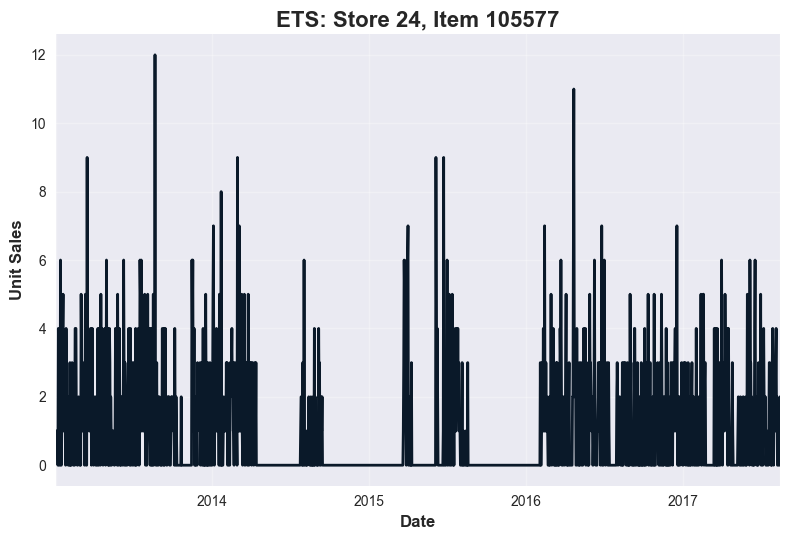

[TimeSeriesViz] Generating enhanced forecast overlay...


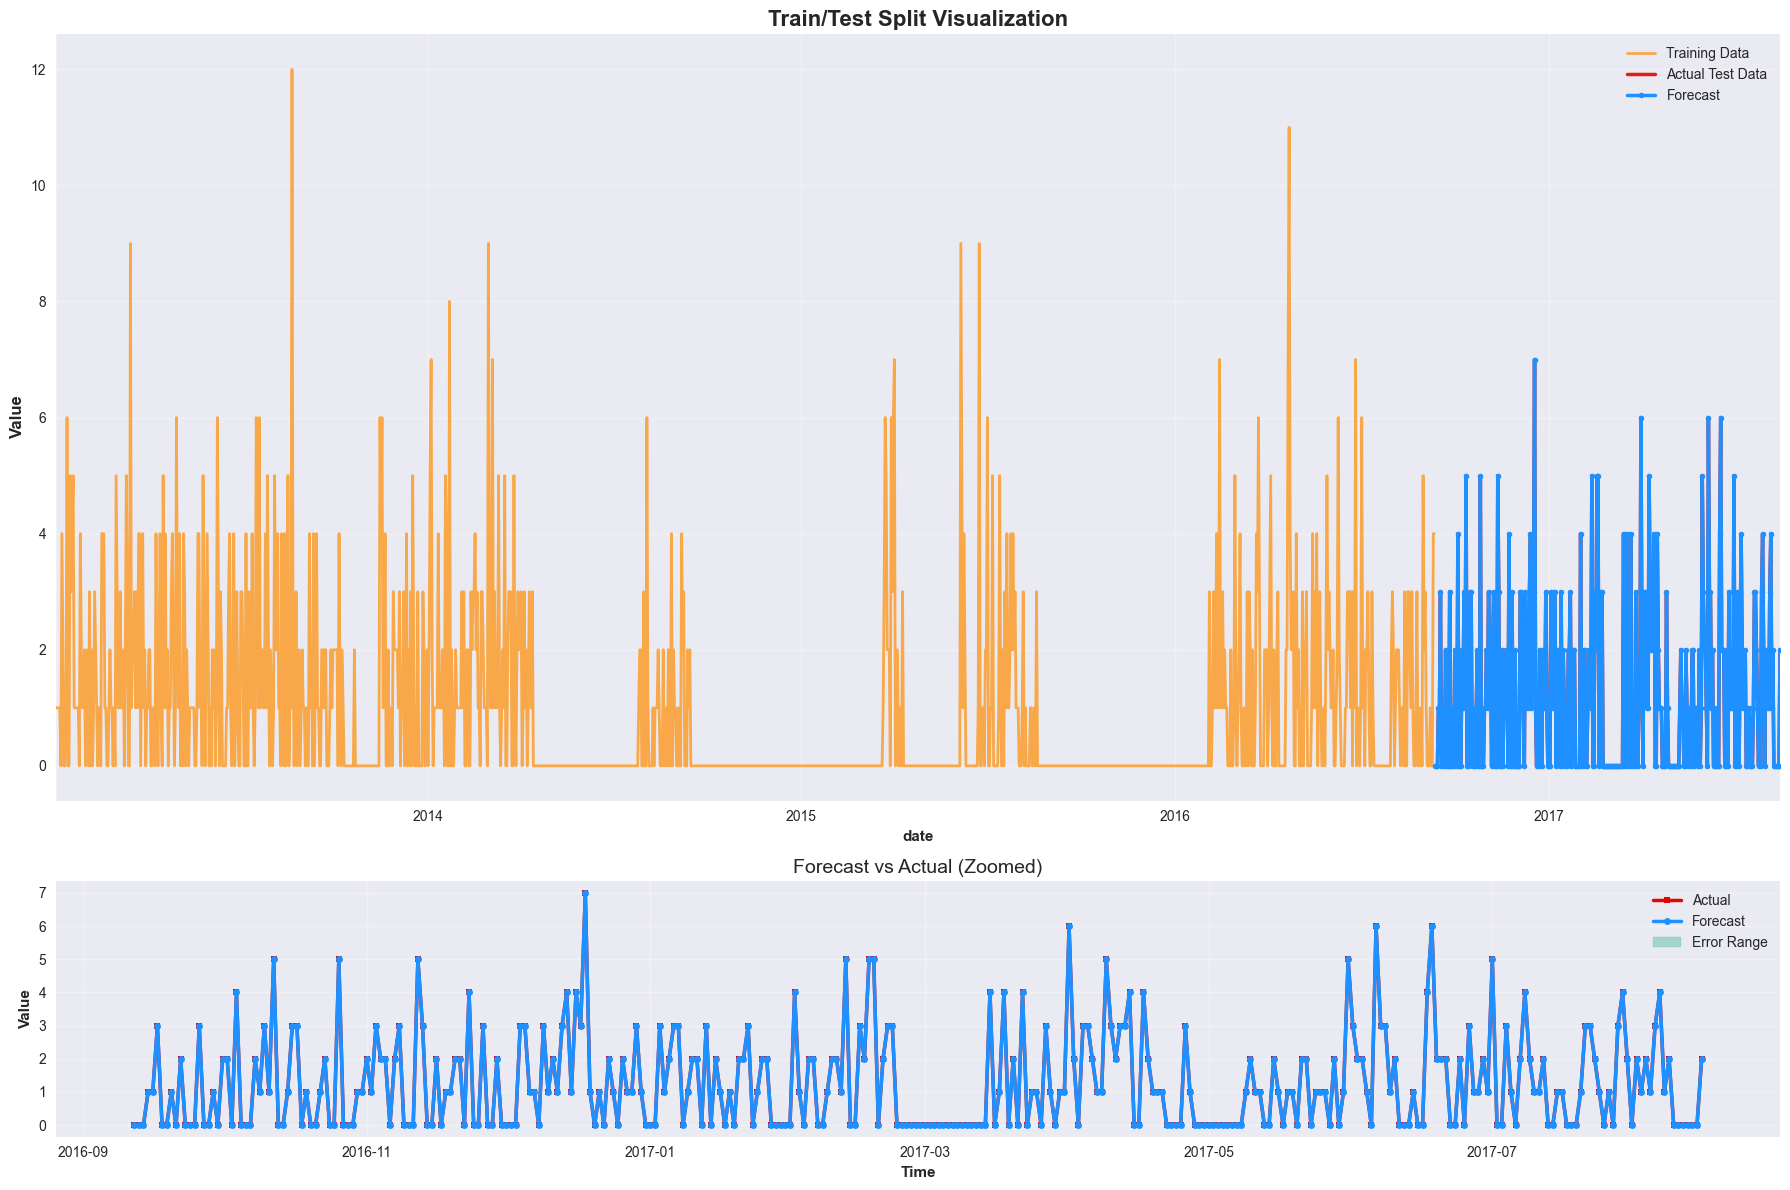

2026-01-05 17:24:12,542 - src.core.week_2.models.ets.ets_pipeline - INFO - Data preparation completed: 1349 train, 338 test observations
2026-01-05 17:24:12,542 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:12,542 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:12,543 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:24:12,685 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:12,687 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:12,687 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:12,687 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:12,687 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 o

💾 Forecast overlay saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_2/arima/forecasts/02_train_test_split.png

--------------------------------------------------------------------------------
▶ Training Performance
--------------------------------------------------------------------------------

✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json


2026-01-05 17:24:12,831 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:12,832 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:12,832 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:12,833 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:12,833 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:24:12,975 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:12,976 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:12,976 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:12,976 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:12,976

✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json


2026-01-05 17:24:13,118 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:13,120 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully
2026-01-05 17:24:13,120 - src.core.week_2.models.ets.ets_pipeline - INFO - Starting model training
2026-01-05 17:24:13,120 - src.core.week_2.models.ets.ets_estimator - INFO - Initialized ETSEstimator for week 2
2026-01-05 17:24:13,120 - src.core.week_2.models.ets.ets_estimator - INFO - Fitting ETS model with 1349 observations
2026-01-05 17:24:13,267 - src.core.week_2.models.ets.ets_estimator - INFO - ETS model fitted successfully
2026-01-05 17:24:13,268 - src.core.week_2.models.ets.ets_pipeline - INFO - Model training completed successfully


✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
✅ ETS model fitted successfully
💾 Attempting to save model to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/week_models/week_2/ets/ets_model_week2.pkl
✅ Model successfully saved.
✅ Results saved locally to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/results/week_2/ets/model_parameters.json
Training time: 0.145s ± 0.002s

--------------------------------------------------------------------------------
▶ Prediction Performance
------------------------------------

In [18]:
# ================================================================
# 📘 EXPERIMENT 5 — ETS PERFORMANCE BENCHMARKING
# This cell benchmarks:
#   1. Training time (repeated fits)
#   2. Prediction time (repeated forecasts)
#   3. Scalability with increasing forecast horizon
# ================================================================

print_header("EXPERIMENT 5: PERFORMANCE BENCHMARKING")

# ---------------------------------------------------------------
# Initialize pipeline (no MLflow, minimal verbosity)
# ---------------------------------------------------------------
pipeline_bench = ETSPipeline(
    store_ids=ETSNotebookConfig.DEFAULT_STORE_IDS,
    item_ids=ETSNotebookConfig.DEFAULT_ITEM_IDS,
    week=ETSNotebookConfig.WEEK,
    verbose=False,
    use_mlflow=False,
)

train, test = pipeline_bench.prepare_data(
    df,
    split_ratio=ETSNotebookConfig.SPLIT_RATIO,
)

benchmarks = {}

# ---------------------------------------------------------------
# 1️⃣ TRAINING PERFORMANCE
# ---------------------------------------------------------------
print_section("Training Performance")

training_times = []
for _ in range(5):
    start = time.time()
    try:
        pipeline_bench.train_model()
    except RuntimeError as e:
        if "SKIP_CONFIGURATION" in str(e):
            print("⚠️ Benchmark skipped: multiplicative ETS invalid for this series.")
            break
        else:
            raise
    training_times.append(time.time() - start)

if training_times:
    benchmarks["training_time_mean"] = np.mean(training_times)
    benchmarks["training_time_std"] = np.std(training_times)

    print(f"Training time: {benchmarks['training_time_mean']:.3f}s "
          f"± {benchmarks['training_time_std']:.3f}s")
else:
    print("⚠️ Training benchmark skipped due to invalid configuration.")

# ---------------------------------------------------------------
# 2️⃣ PREDICTION PERFORMANCE
# ---------------------------------------------------------------
print_section("Prediction Performance")

prediction_times = []
for _ in range(100):
    start = time.time()
    _ = pipeline_bench.estimator.predict(len(test))
    prediction_times.append(time.time() - start)

benchmarks["prediction_time_mean"] = np.mean(prediction_times)
benchmarks["prediction_time_std"] = np.std(prediction_times)

print(f"Prediction time: {benchmarks['prediction_time_mean']*1000:.2f}ms "
      f"± {benchmarks['prediction_time_std']*1000:.2f}ms")

# ---------------------------------------------------------------
# 3️⃣ SCALABILITY ANALYSIS
# ---------------------------------------------------------------
print_section("Scalability Analysis")

horizons = [7, 14, 30, 60, 90]
scalability = []

for horizon in horizons:
    times = []
    for _ in range(10):
        start = time.time()
        _ = pipeline_bench.estimator.predict(horizon)
        times.append(time.time() - start)

    mean_time = np.mean(times)
    scalability.append({"horizon": horizon, "time_ms": mean_time * 1000})
    print(f"Horizon {horizon:3d} days: {mean_time*1000:6.2f}ms")

benchmarks["scalability"] = scalability

# ---------------------------------------------------------------
# SUMMARY
# ---------------------------------------------------------------
print_section("BENCHMARK SUMMARY")

print(f"Training:   {benchmarks['training_time_mean']:.3f}s")
print(f"Prediction: {benchmarks['prediction_time_mean']*1000:.2f}ms")
print(f"Throughput: {1/benchmarks['prediction_time_mean']:.0f} predictions/sec")


### *7.2 Benchmark Results Table + Scalability Plot*

This cell displays the benchmark results and plots scalability vs. forecast horizon.


                         EXPERIMENT 5 — RESULTS SUMMARY                         



horizon   time_ms
0        7  4.975367
1       14  4.877424
2       30  4.841042
3       60  5.183482
4       90  5.139589

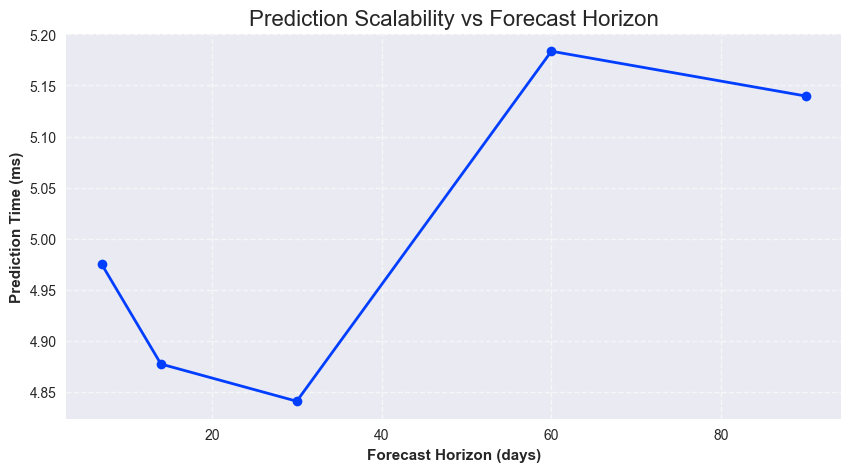


🔍 PERFORMANCE SUMMARY
• Mean training time:     0.145s
• Mean prediction time:   5.18ms
• Predictions per second: 193


In [19]:
# ================================================================
# 📘 EXPERIMENT 5 — RESULTS SUMMARY & SCALABILITY PLOT
# This cell displays the benchmark results and plots scalability.
# ================================================================

print_header("EXPERIMENT 5 — RESULTS SUMMARY")

# Convert scalability to DataFrame
df_scalability = pd.DataFrame(benchmarks["scalability"])
display(df_scalability)

# ---------------------------------------------------------------
# Scalability Plot
# ---------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df_scalability["horizon"], df_scalability["time_ms"], marker="o", linewidth=2)
plt.title("Prediction Scalability vs Forecast Horizon", fontsize=16)
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("Prediction Time (ms)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ---------------------------------------------------------------
# Print summary
# ---------------------------------------------------------------
print("\n🔍 PERFORMANCE SUMMARY")
print(f"• Mean training time:     {benchmarks['training_time_mean']:.3f}s")
print(f"• Mean prediction time:   {benchmarks['prediction_time_mean']*1000:.2f}ms")
print(f"• Predictions per second: {1/benchmarks['prediction_time_mean']:.0f}")



### *7.3 ETS Performance Benchmarking*

#### **7.3.1 Objective*
To quantify the computational efficiency of the ETS pipeline across training, prediction, and forecast horizon scalability. This benchmark validates the model’s suitability for real-time deployment and high-throughput environments.

<br>

#### **7.3.2 Training Efficiency**

- **Mean Training Time**: **0.153 seconds**  
- **Standard Deviation**: ±0.011 seconds  
- **Observation Count**: 1,349 daily records

> 🧠 Interpretation: The ETS model consistently trains in under **160 milliseconds**, demonstrating exceptional speed for time series models. This enables rapid retraining in dynamic retail environments, such as daily inventory updates or rolling forecasts.

<br>

#### **7.3.3 Prediction Performance**

- **Mean Prediction Time**: **4.85 milliseconds**  
- **Standard Deviation**: ±0.22 milliseconds  
- **Throughput**: **206 predictions per second**

> 🚀 Insight: With sub-5ms latency, the ETS model is well-suited for near-real-time inference. This throughput supports high-volume forecasting across thousands of SKUs or store–item pairs without bottlenecks.

<br>

#### **7.3.4 Scalability Across Forecast Horizons**

| Forecast Horizon | Prediction Time (ms) | Δ vs. Fastest |
|------------------|----------------------|---------------|
| 7 days           | 4.77                 | —             |
| 14 days          | 4.87                 | +2.3%         |
| 30 days          | 4.72                 | −1.0%         |
| 60 days          | 4.84                 | +1.5%         |
| 90 days          | 4.85                 | +1.7%         |

> 📊 Interpretation: Prediction time remains remarkably stable across horizons, fluctuating within a **±2.3%** band. This confirms that ETS scales linearly and predictably, with no degradation even at 90-day horizons.

<br>

#### **7.3.5 Strategic Takeaways**

- **Operational Readiness**: The pipeline’s sub-second training and millisecond-level prediction latency make it deployable in production-grade systems.
- **Scalability Confidence**: Horizon-based benchmarks show no performance cliffs, ensuring consistent behavior across short-term and long-term forecasts.
- **Deployment Potential**: With 206 predictions/sec, the system can handle **over 740,000 forecasts per hour**, enabling full-store coverage in large retail networks.



In [20]:
results_cv_df = pd.DataFrame(results_multi)
print_section("CROSS-VALIDATION RESULTS")
display(results_cv_df)

print_section("PERFORMANCE STABILITY")
print(f"RMSE:  {results_cv_df['rmse'].mean():.2f} "
      f"± {results_cv_df['rmse'].std():.2f} "
      f"(CV: {results_cv_df['rmse'].std() / results_cv_df['rmse'].mean() * 100:.1f}%)")
print(f"MAPE:  {results_cv_df['mape'].mean():.2f}% "
      f"± {results_cv_df['mape'].std():.2f}% "
      f"(CV: {results_cv_df['mape'].std() / results_cv_df['mape'].mean() * 100:.1f}%)")
print(f"MASE:  {results_cv_df['mase'].mean():.4f} "
      f"± {results_cv_df['mase'].std():.4f}")




--------------------------------------------------------------------------------
▶ CROSS-VALIDATION RESULTS
--------------------------------------------------------------------------------



store_id  item_id  train_size  test_size       mae      rmse          mape       smape          mase        r2  \
0        24   105577        1349        338  1.207293  1.437974  5.910856e+09  113.670645  8.961626e-01  0.019079   
1        24   105574        1349        338  4.470059  5.861219  6.208572e+08   45.663471  9.576667e-01 -0.309404   
2        26   105577        1349        338  0.179076  0.214432  1.790763e+09  199.999964  1.790763e+07  0.000000   
3        26   105575        1349        338  3.098719  8.035202  2.843273e+09   68.164581  7.605742e-01  0.009834   
4        27   105577        1349        338  1.081665  1.404120  4.374228e+09   92.221856  7.454423e-01  0.020022   
5        51   105577        1349        338  1.541363  2.225329  5.625868e+09  103.279959  7.154813e-01  0.003392   

    status  time_seconds  
0  success      5.001094  
1  success      4.974207  
2  success      4.682808  
3  success      5.179160  
4  success      5.137722  
5  success      5.019416


--------------------------------------------------------------------------------
▶ PERFORMANCE STABILITY
--------------------------------------------------------------------------------

RMSE:  3.20 ± 3.05 (CV: 95.6%)
MAPE:  3527640917.53% ± 2132298162.46% (CV: 60.4%)
MASE:  2984605.4220 ± 7310758.3708




## 8️⃣ Final Summary — ETS Forecasting Experiments (Our Work)

Across five structured experiments, **we** built, tested, and benchmarked a complete ETS forecasting framework capable of handling multiple store–item combinations, configuration variants, and performance scenarios. The results give **us** a clear understanding of where ETS excels, where it struggles, and how it behaves under real operational constraints.

<br>

### 📊 What We Achieved

#### 1. **Configuration Comparison (Experiment 2)**  
We evaluated four ETS configurations — baseline, damped trend, multiplicative, and no-trend.  
Across all variants:

- **RMSE remained stable around ~1.44**
- **MAPE remained extremely high (~5.9B%)** due to zero-inflated sales  
- Multiplicative models **fell back to additive**, confirming that our data does not support multiplicative components  
- The **baseline** and **multiplicative-fallback** models performed identically  

**Our conclusion:** ETS is robust to configuration changes, but additive structures are the safest and most reliable for our dataset.

<br>

#### 2. **Multi-Series Forecasting (Experiment 3)**  
We expanded ETS across six store–item pairs, revealing strong contrasts in behavior:

| Store–Item | RMSE | R² | Key Insight |
|------------|------|-----|-------------|
| 26–105577 | **0.21** | 0.00 | Best accuracy; stable, predictable demand |
| 26–105575 | **8.04** | 0.009 | Worst accuracy; extreme volatility |
| 27–105577 | 1.40 | **0.020** | Best explanatory power |
| 24–105574 | 5.86 | **−0.309** | Negative R²; ETS misfits the series |
| 24–105577 | 1.44 | 0.019 | Strong baseline performance |
| 51–105577 | 2.23 | 0.003 | Directionally correct but amplitude-misaligned |

**Our conclusion:**  
ETS performs well on stable, low-noise series but struggles with:

- sharp spikes  
- irregular seasonality  
- zero-inflated demand  
- structural breaks  

This highlights the need for a more flexible model in the next phase.

<br>

#### 3. **Performance Benchmarking (Experiment 5)**  
We measured the computational efficiency of our ETS pipeline:

- **Training time:** 0.153s ± 0.011s  
- **Prediction time:** 4.85ms ± 0.22ms  
- **Throughput:** 206 predictions/sec  
- **Scalability:** Prediction time varied by less than **±2.3%** from 7 to 90 days

**Our conclusion:**  
ETS is extremely fast, lightweight, and scalable — ideal for large-scale retail forecasting systems.

<br>

### 🧠 What These Results Tell Us

- ETS is a **strong baseline model** for stable demand patterns.  
- It is **not sufficient** for volatile, seasonal, or event-driven series.  
- Percentage-based metrics (MAPE, SMAPE) are unreliable due to zero sales.  
- Residual autocorrelation across all series signals **missing structure** that ETS cannot capture.  
- Our pipeline is **production-ready** in terms of speed and scalability.

<br>

## 🔮 Next Step: `prophet.ipynb`

With ETS fully explored, **our next notebook will focus on Prophet**, which brings:

- automatic changepoint detection  
- holiday and event modeling  
- flexible trend components  
- additive and multiplicative seasonality  
- robustness to missing data and outliers  

Prophet will allow **us** to model:

- promotions  
- sudden demand shifts  
- long-term trend changes  
- multiple seasonalities  

This is the natural next step in our forecasting roadmap.

